<a href="https://colab.research.google.com/github/peeyushsinghal/da/blob/main/mitigating_bias_sa_da_v28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mitigating bias in sentiment analysis using domain adaptation

In [1]:
! pip install torchtext==0.10.0 --quiet # DOWNGRADE YOUR TORCHTEXT
! pip install ekphrasis --quiet # library to pre process twitter data
! pip install emoji --upgrade --quiet #library to deal with emoji data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 1.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.0+cu116 requires torch==1.13.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.13.0+cu116 requires torch==1.13.0, but you have torch 1.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
## Import statements
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.legacy.data import Dataset, Field, TabularDataset, BucketIterator
from torchtext.vocab import GloVe
import torchtext.vocab as vocab
import numpy as np
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import emoji
from torchtext.legacy.vocab import Vectors
from tqdm import tqdm
import random
import torch.optim as optim
import scipy.stats as stats
from statistics import mean

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))

import time

from copy import deepcopy

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import matplotlib.pyplot as plt
# import EarlyStopping
# from pytorchtools import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# checking device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:{}".format(DEVICE))

Running on:cpu


## Data loading

In [4]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data Configuration

In [5]:

BASE_PATH = '/content/drive/MyDrive/semeval-2018'

DATA_DIR = os.path.join(BASE_PATH,'datasets')
TARGET_DIR = os.path.join(BASE_PATH,'targetdataset')

MODEL_DIR = os.path.join(BASE_PATH,'models')
REF_DIR = os.path.join(BASE_PATH,'reference')
EMBEDDINGS_DIR = os.path.join(BASE_PATH,'embeddings')

MAX_SIZE = 50
MAX_VOCAB_SIZE = 10000
BATCH_SIZE = 8

EMBEDDING_TO_BE_USED = 'glove_gn' # {'glove', 'glove_gn'}
TARGET_BATCH_SIZE = 8

NUM_EPOCHS = 100
# NUM_EPOCHS = 2
# NUM_EPOCHS = 50
LR = 2e-4

PATIENCE = 10
EWC_LAMBDA = 0.4

if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR)
  print("The new directory is created!")


BONFERRONI_CORRECTION = 5.0

In [6]:
# data configuration

class TASK1(object):
  
    EI_reg = {
        'anger': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-anger-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-anger-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-anger-test-gold.txt')
                },
        'joy': {
                'train': os.path.join(
                    DATA_DIR, 'task1/EI-reg/training/EI-reg-En-joy-train.txt'),
                'dev': os.path.join(
                    DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-joy-dev.txt'),
                'gold': os.path.join(
                    DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-joy-test-gold.txt')
                },
        'fear': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-fear-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-fear-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-fear-test-gold.txt')
                },
        'sadness': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-sadness-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-sadness-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-sadness-test-gold.txt')
                }                     
        }

    V_reg = {
        'train': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-train.txt'),
        'dev': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-dev.txt'),
        'gold': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-test-gold.txt')
             }

    EEC = {
        'eec': os.path.join(
            DATA_DIR, 'task1/Equity-Evaluation-Corpus/Equity-Evaluation-Corpus.csv')
             }

## Source Data
Parsing Emotion and Valence regression data : `format [ID	Tweet	Affect Dimension	Intensity Score]`

In [7]:
def parse_reg(data_file, label_format='tuple'):
    """
    This is for datasets for the EI-reg and V-reg English tasks 
    Returns:
        df: dataframe with columns in the first row of file [ID-Tweet-Affect Dimension-Intensity Score]
    """
    with open(data_file, 'r') as fd:
      data = [l.strip().split('\t') for l in fd.readlines()]
    # print(data)
    df = pd.DataFrame (data[1:],columns=data[0])
    csv_file_name = (data_file.split("/")[-1]).split('.')[0]+".csv"
    csv_file = df.to_csv(str(csv_file_name))
    return csv_file_name


Generic Source Data Parser

In [8]:
def parse_csv(task, dataset, emotion='anger'):
    if task == 'EI-reg':
        data_train = TASK1.EI_reg[emotion][dataset]
        csv_file_name = parse_reg(data_train)
        return csv_file_name

    elif task == 'V-reg':
        data_train = TASK1.V_reg[dataset]

        csv_file_name = parse_reg(data_train)
        return csv_file_name

    else:
        return None

In [9]:
emotions = ['anger','joy','fear','sadness']
dict_data ={'train':'train','dev':'val','gold':'test'}
dict_file_name ={}
for emotion in emotions:
  for data_info, data_usage in dict_data.items():
    file_name = str('file_EI_'+ emotion + "_" + data_usage)
    dict_file_name[file_name] = parse_csv('EI-reg', data_info, emotion)

    file_name2 = str('file_V_'+ data_usage)
    dict_file_name[file_name2] = parse_csv('V-reg', data_info)

(dict_file_name)

{'file_EI_anger_train': 'EI-reg-En-anger-train.csv',
 'file_V_train': '2018-Valence-reg-En-train.csv',
 'file_EI_anger_val': '2018-EI-reg-En-anger-dev.csv',
 'file_V_val': '2018-Valence-reg-En-dev.csv',
 'file_EI_anger_test': '2018-EI-reg-En-anger-test-gold.csv',
 'file_V_test': '2018-Valence-reg-En-test-gold.csv',
 'file_EI_joy_train': 'EI-reg-En-joy-train.csv',
 'file_EI_joy_val': '2018-EI-reg-En-joy-dev.csv',
 'file_EI_joy_test': '2018-EI-reg-En-joy-test-gold.csv',
 'file_EI_fear_train': 'EI-reg-En-fear-train.csv',
 'file_EI_fear_val': '2018-EI-reg-En-fear-dev.csv',
 'file_EI_fear_test': '2018-EI-reg-En-fear-test-gold.csv',
 'file_EI_sadness_train': 'EI-reg-En-sadness-train.csv',
 'file_EI_sadness_val': '2018-EI-reg-En-sadness-dev.csv',
 'file_EI_sadness_test': '2018-EI-reg-En-sadness-test-gold.csv'}

## Preprocess tweets

In [10]:
# reference : https://github.com/cbaziotis/ekphrasis


text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.8/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


/usr/local/lib/python3.8/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


In [11]:
def preprocess_tweet(tweet): 
  tweet_processed = text_processor.pre_process_doc(tweet)
  # print (tweet_processed)
  demojized_list =[]
  final_list =[]
  for index, tweet in enumerate(tweet_processed):
      demojized_list.append(emoji.demojize(tweet, language = 'en'))
  final_list = [w for w in demojized_list if w not in en_stops] 
  
  # print(df)
  return final_list

## TorchText Treatment

In [12]:
dict_file_name.keys()

dict_keys(['file_EI_anger_train', 'file_V_train', 'file_EI_anger_val', 'file_V_val', 'file_EI_anger_test', 'file_V_test', 'file_EI_joy_train', 'file_EI_joy_val', 'file_EI_joy_test', 'file_EI_fear_train', 'file_EI_fear_val', 'file_EI_fear_test', 'file_EI_sadness_train', 'file_EI_sadness_val', 'file_EI_sadness_test'])

In [13]:
dict_fields ={}
list_name = list(set(["_".join(key.split("_")[1:-1]) for key in list(dict_file_name.keys())]))


for name in list_name:
  field_tweet = Field(sequential=True, 
                      use_vocab = True, 
                      tokenize = preprocess_tweet, 
                      fix_length = MAX_SIZE, 
                      batch_first = True)
  field_intensity = Field(sequential= False, 
                        dtype = torch.float,
                        use_vocab = False)
  fields = {
    'Tweet':('tweet', field_tweet ), #
    'Intensity Score': ('intensity',field_intensity) # Intensity Score is name of the dataset column, field_intensity is how we have defined the field, intensity is the name of the variable going fwd
    }
  
  dict_fields[name] = fields

dict_fields

{'EI_anger': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7f6c1e7ecfd0>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7f6c1e7ec700>)},
 'V': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7f6c1e7eceb0>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7f6c1e7ecbe0>)},
 'EI_sadness': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7f6c1e7ecdf0>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7f6c1e7ec7c0>)},
 'EI_joy': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7f6c1e7ece80>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7f6c1e7ecf70>)},
 'EI_fear': {'Tweet': ('tweet',
   <torchtext.legacy.data.field.Field at 0x7f6c1e7ecee0>),
  'Intensity Score': ('intensity',
   <torchtext.legacy.data.field.Field at 0x7f6c1e7eca30>)}}

In [14]:
dict_fields['EI_sadness']['Tweet'][1]

In [15]:
dict_dataset ={}
for file_key, file_name in dict_file_name.items():
  # print(file_key,file_name)
  if "train" in (file_key.split("_")[-1]):
    head_name = "_".join(file_key.split("_")[0:-1])
    base_name = "_".join(file_key.split("_")[1:-1])
    # print(base_name)
    train_file = dict_file_name[head_name+"_train"]
    val_file = dict_file_name[head_name+"_val"]
    test_file =  dict_file_name[head_name+"_test"]

    train, val, test =TabularDataset.splits( path = './', 
                                            train = train_file, 
                                            validation = val_file, 
                                            test = test_file,
                                            format = 'csv', 
                                            fields = dict_fields[base_name])
    
  
    dict_dataset[base_name] = {"train_dataset": train, "val_dataset":val,"test_dataset":test}

In [16]:
dict_dataset

{'EI_anger': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f6c05341c10>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f6c05341b20>,
  'test_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f6c1e947ac0>},
 'V': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f6c0477d190>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f6c04419f40>,
  'test_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f6c03c1c7f0>},
 'EI_joy': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f6c02e4d550>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f6c02da26d0>,
  'test_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f6c05341c70>},
 'EI_fear': {'train_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f6c03327100>,
  'val_dataset': <torchtext.legacy.data.dataset.TabularDataset at 0x7f6c04baa430>,
  'test_dataset': <torchtext.legacy

In [17]:
for key, value in dict_dataset.items():
  # count = 0
  for name, dataset in value.items():
    for example in dataset.examples:
      print(key, name, example.tweet, example.intensity)
      break


EI_anger train_dataset ['<user>', '<user>', 'shut', 'hashtags', 'cool', '<hashtag>', 'offended', '</hashtag>'] 0.562
EI_anger val_dataset ["'", 'need', 'something', '.', 'something', 'must', 'done', '!', '<repeated>', "'", '\\', 'n', '\\', 'nyour', 'anxiety', 'amusing', '.', 'nothing', 'done', '.', 'despair', '.'] 0.517
EI_anger test_dataset ['<user>', 'know', 'mean', 'well', 'offended', '.', 'prick', '.'] 0.734
V train_dataset ['<user>', 'yeah', '!', '<happy>', 'playing', 'well'] 0.600
V val_dataset ['<user>', 'site', 'crashes', 'everytime', 'try', 'book', '-', 'help', '?', 'tell', "'", 'nothing', 'wrong', '&', 'hang', '<hashtag>', 'furious', '</hashtag>', '<hashtag>', 'helpless', '</hashtag>', '<user>'] 0.141
V test_dataset ['gm', '<hashtag>', 'tuesday', '</hashtag>', '!'] 0.589
EI_joy train_dataset ['<user>', 'quite', 'saddened', '.', '<repeated>', 'us', 'dates', ',', 'joyous', 'anticipation', 'attending', 'dg', 'concert', '(', 'since', '<number>', ')', '.', 'happy', 'keeping', 'bus

## Building iterator and Vocabulary

In [18]:
for name, value in dict_fields.items():
  print(name, value)

EI_anger {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f6c1e7ecfd0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f6c1e7ec700>)}
V {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f6c1e7eceb0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f6c1e7ecbe0>)}
EI_sadness {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f6c1e7ecdf0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f6c1e7ec7c0>)}
EI_joy {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f6c1e7ece80>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f6c1e7ecf70>)}
EI_fear {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f6c1e7ecee0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f6c1e7eca30>)}


In [19]:
dict_emb_file = {'glove':'glove.6B.300d.txt',
                 'glove_gn': '1b-vectors300-0.8-0.8.txt'}

print("EMBEDDING_TO_BE_USED:", EMBEDDING_TO_BE_USED)
emb_file_path = os.path.join(EMBEDDINGS_DIR ,dict_emb_file[EMBEDDING_TO_BE_USED])
emb_file_path

EMBEDDING_TO_BE_USED: glove_gn


'/content/drive/MyDrive/semeval-2018/embeddings/1b-vectors300-0.8-0.8.txt'

In [20]:

for name, value in dict_fields.items():
  print(name, value['Tweet'][1])
  
  ## start for embeddings from text file
  value['Tweet'][1].build_vocab(dict_dataset[name]['train_dataset'])
  vectors = vocab.Vectors(emb_file_path) # location of embeddings file, full path
  value['Tweet'][1].vocab.set_vectors(vectors.stoi, vectors.vectors, vectors.dim)
  ## end for embeddings from text file

  value['Intensity Score'][1].build_vocab(dict_dataset[name]['train_dataset'])


EI_anger <torchtext.legacy.data.field.Field object at 0x7f6c1e7ecfd0>


100%|█████████▉| 142526/142527 [00:12<00:00, 11161.63it/s]


V <torchtext.legacy.data.field.Field object at 0x7f6c1e7eceb0>
EI_sadness <torchtext.legacy.data.field.Field object at 0x7f6c1e7ecdf0>
EI_joy <torchtext.legacy.data.field.Field object at 0x7f6c1e7ece80>
EI_fear <torchtext.legacy.data.field.Field object at 0x7f6c1e7ecee0>


In [21]:
dict_iterator ={}
for name, value in dict_dataset.items():
  VALID_BATCH_SIZE = len(value['val_dataset']) - 1
  TEST_BATCH_SIZE = len(value['test_dataset'])  -1
  # VALID_TEST_BATCH_SIZE= min(len(value['val_dataset']),len(value['test_dataset']) )
  print(name, VALID_BATCH_SIZE , TEST_BATCH_SIZE)
  train_iterator, val_iterator, test_iterator= BucketIterator.splits(
      (value['train_dataset'], value['val_dataset'],value['test_dataset']),
      batch_sizes= (BATCH_SIZE,VALID_BATCH_SIZE, TEST_BATCH_SIZE),
      sort_key = lambda x: len(x.tweet),
      sort_within_batch=True,
      device = DEVICE,
      shuffle= True)
  
  dict_iterator[name] = {"train_iterator": train_iterator, "val_iterator":val_iterator,"test_iterator":test_iterator}


EI_anger 387 1001
V 448 936
EI_joy 289 1104
EI_fear 388 985
EI_sadness 396 974


In [22]:
dict_iterator.items()

dict_items([('EI_anger', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6c00634c70>, 'val_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6c00634d30>, 'test_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6c00634d90>}), ('V', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6c00634f40>, 'val_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6c006ae0d0>, 'test_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6c006ae160>}), ('EI_joy', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6c006ae400>, 'val_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6c006ae4c0>, 'test_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6c006ae550>}), ('EI_fear', {'train_iterator': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6c006ae7f0>, 'val_iterator': <torchtex

In [23]:
# for key, value in dict_iterator.items():
#   for name, iterator in value.items():
#     for batch in iterator:
#       print(key, name, batch.tweet)
#       print(batch.intensity)
#       break
#     break
#   break


In [24]:
for name in list_name:
  print(dict_fields[name]['Tweet'][1].vocab.stoi.items())

dict_items([('<unk>', 0), ('<pad>', 1), ('</hashtag>', 2), ('<hashtag>', 3), ('.', 4), ('<user>', 5), (',', 6), ("'", 7), ('!', 8), ('<repeated>', 9), ('<number>', 10), ('?', 11), ('</allcaps>', 12), ('<allcaps>', 13), ('-', 14), ('like', 15), ('\\', 16), ('people', 17), ('get', 18), ('anger', 19), ('angry', 20), ('n', 21), ('rage', 22), ('one', 23), ('bitter', 24), ('&', 25), ('fuming', 26), ('revenge', 27), ('snap', 28), ('offended', 29), (':face_with_tears_of_joy:', 30), ('u', 31), ('got', 32), ('outrage', 33), (':', 34), ('<elongated>', 35), ('think', 36), ('know', 37), ('time', 38), ('would', 39), ('/', 40), ('lol', 41), ('never', 42), ('even', 43), ('burning', 44), ('furious', 45), ('someone', 46), ('sting', 47), ('today', 48), ('back', 49), ('raging', 50), ('really', 51), ('(', 52), ('love', 53), ('madden', 54), ('need', 55), ('want', 56), (')', 57), ('going', 58), ('man', 59), ('offend', 60), ('go', 61), ('fury', 62), ('see', 63), ('best', 64), ('insult', 65), ('kik', 66), ('of

## TorchText treatment of Target Data

In [25]:
# Target Data
df_target = pd.read_csv(os.path.join(TARGET_DIR,'winomt_saunders_combined.csv'))
print(df_target.head())
target_file_name = 'target_csv.csv'
target_csv_file = df_target.to_csv(str(target_file_name))

                             Tweet  Intensity Score
0    the actor finished her work .                0
1    the actor finished his work .                0
2  the actuary finished her work .                0
3  the actuary finished his work .                0
4    the agent finished her work .                0


In [26]:
dict_target_dataset = {}
for name in list_name:
  # print(dict_fields[name])
  dict_target_dataset [name] = TabularDataset( path = os.path.join(TARGET_DIR,'winomt_saunders_combined.csv'), 
                                              format = 'csv',
                                              fields = dict_fields[name] )

print(dict_target_dataset)

{'EI_anger': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f6c8fbd3580>, 'V': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f6c8fbd3ca0>, 'EI_sadness': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f6c00c5e4c0>, 'EI_joy': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f6c00e07880>, 'EI_fear': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f6c00b94730>}


In [27]:
for name, dataset in dict_target_dataset.items():
  count=0
  for example in dataset:
    print(example.tweet, example.intensity)
    count += 1
    if count > 2:
      break

['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0


In [28]:
dict_target_iterator = {}
for name in list_name:
  dict_target_iterator [name] = BucketIterator(dict_target_dataset[name], # given that there is only one dataset we are not using splits
                                 batch_size= TARGET_BATCH_SIZE,
                                 sort_key = lambda x: len(x.tweet),
                                 sort_within_batch=True,
                                 device = DEVICE,
                                 repeat=True,
                                 shuffle= True)

print(dict_target_iterator)

{'EI_anger': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6bfed52250>, 'V': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6bfed52220>, 'EI_sadness': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6bfed52190>, 'EI_joy': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6bfed520d0>, 'EI_fear': <torchtext.legacy.data.iterator.BucketIterator object at 0x7f6bfed523a0>}


In [29]:
# next(iter(target_iterator))

In [30]:
for name, iterator in dict_target_iterator.items():
  count = 0
  for batch in iterator:
    print(name)
    print(batch)
    print (batch.tweet)
    print (batch.intensity)
    count += 1
    break
    if count > 2:
      break

EI_anger

[torchtext.legacy.data.batch.Batch of size 8]
	[.tweet]:[torch.LongTensor of size 8x50]
	[.intensity]:[torch.FloatTensor of size 8]
tensor([[   0,    0,    0,    0,   64, 3425,    4,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [   0,    0,    0,    0,    0,  234,    4,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [   0,    0,    0,  565,  438, 3659,    4,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
    

## CNN 1d model

### Gradient Reversal layer

In [31]:
from torch.autograd import Function


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

CNN 1 D model
Reference: A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification, Ye Zhang, Byron Wallace 2015

Difference:

use of embedding
use of sigmoid function, as we are having a regression model not a classififer as the main task

In [32]:
import torch.nn as nn
import torch.nn.functional as F

class CNN1d(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 n_filters, 
                 filter_sizes, 
                 output_dim, 
                 dropout, 
                 pad_idx
                 ):
        super().__init__()
        
        #---------------------Feature Extractor Network----------------------#
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        # Convolutional Network
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        #---------------------Regression Network------------------------#
        # Fully-connected layer and Dropout
        self.regression = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(len(filter_sizes) * n_filters, len(filter_sizes) * n_filters // 2),
            nn.ReLU(),
            nn.Linear(len(filter_sizes) * n_filters // 2, output_dim * 10),
            nn.ReLU(),
            nn.Linear(output_dim * 10, output_dim)
            # ,
            # nn.Sigmoid()
        )
        # self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim * 10)
        # self.fc2 = nn.Linear(output_dim * 10, output_dim)
        # self.dropout = nn.Dropout(dropout)

        #---------------------Domain Classifier Network------------------------#
        # Fully-connected layer and Dropout
        self.domain_classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(len(filter_sizes) * n_filters, len(filter_sizes) * n_filters // 2),
            nn.ReLU(),
            nn.Linear(len(filter_sizes) * n_filters // 2, output_dim * 10),
            nn.ReLU(),
            nn.Linear(output_dim * 10, 2),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, text, alpha=1.0):
        
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)
        
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        x_feature = torch.cat(pooled, dim = 1)
        
        #x_feature = [batch size, n_filters * len(filter_sizes)]
        
        reverse_feature = GradientReversalFn.apply(x_feature, alpha)
        # print("reverse_feature",reverse_feature)
    
        regression_output = self.regression(x_feature)
    
        domain_classifier_output = self.domain_classifier(reverse_feature)


        return regression_output, domain_classifier_output

In [33]:
# INPUT_DIM = len(field_tweet.vocab) # these change for each model
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2, 3, 4, 5]
OUTPUT_DIM = 1
DROPOUT = 0.5
# PAD_IDX = field_tweet.vocab.stoi[field_tweet.pad_token] # these change for each model

### Model Architecture Creation for each variant, Loading pre-trained embeddings

In [34]:
dict_model_arch ={}
for name in list_name:
  
  # INPUT_DIM = len(field_tweet.vocab) # single model
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  # print(INPUT_DIM)

  # PAD_IDX = field_tweet.vocab.stoi[field_tweet.pad_token] # # single model
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]
  # print(PAD_IDX)

  dict_model_arch[name] = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  dict_model_arch[name].to(DEVICE)

  # pretrained_embeddings = field_tweet.vocab.vectors # single model
  pretrained_embeddings = dict_fields[name]['Tweet'][1].vocab.vectors

  # model.embedding.weight.data.copy_(pretrained_embeddings) # single model
  # dict_model_arch[name].embedding.weight.data.copy_(pretrained_embeddings)

  ## start for embeddings from text file
  dict_model_arch[name].embedding.from_pretrained(torch.FloatTensor(dict_fields[name]['Tweet'][1].vocab.vectors))
  ## end for embeddings from text file

  # UNK_IDX = field_tweet.vocab.stoi[field_tweet.unk_token] # single model
  UNK_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].unk_token]

  # model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) # single model
  dict_model_arch[name].embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) 
  
  # model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM) # single model
  dict_model_arch[name].embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM) 

dict_model_arch

{'EI_anger': CNN1d(
   (embedding): Embedding(4689, 100, padding_idx=1)
   (convs): ModuleList(
     (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
     (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
     (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
     (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
   )
   (regression): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=400, out_features=200, bias=True)
     (2): ReLU()
     (3): Linear(in_features=200, out_features=10, bias=True)
     (4): ReLU()
     (5): Linear(in_features=10, out_features=1, bias=True)
   )
   (domain_classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=400, out_features=200, bias=True)
     (2): ReLU()
     (3): Linear(in_features=200, out_features=10, bias=True)
     (4): ReLU()
     (5): Linear(in_features=10, out_features=2, bias=True)
     (6): LogSoftmax(dim=1)
   )
 ), 'V': CNN1d(
   (embedding): Embedding(4320

In [35]:
# model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
# model.to(DEVICE)

## Training the model

### Without training one forward pass

In [ ]:
for name, model_arch in dict_model_arch.items():
  for batch in dict_iterator[name]['train_iterator']:
    print(batch.tweet)
    output = model_arch(batch.tweet)
    print (output)
    break

tensor([[ 936,  512,  607,  370,  161,    4,    3,  502,    2,    3,   17,    2,
            3, 3991,    2,    3, 1607,    2,    3, 1214,    2,    3, 4821,    2,
            3,   54, 4008,    2,    3, 2799,    2,    3,  322,  354,  370,    2,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [4155,  864, 1382, 4291,    7,  864, 1382,    7,  228,  228,  434, 1095,
          537,   15, 3479,   14, 1563,  147,    3, 1305,  147,    2,    3, 1563,
          147,    2,    3, 1773,    2,    3,   23,    2,    3,  581,  599,    2,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [  43,   82,  348,    4,    8, 2251, 1133, 1133, 1133,    3,   22,    2,
            3,   93,    2,    3, 1977,    2,    3,  335,    2,    3,   24,    2,
           10, 3665,  471,  658,  390,    4,    8, 4300,    3, 2137, 2260,    2,
            1,    1,    1,    1,    1,    1,    1,    1,    1,   

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Typical Train Model Function

In [ ]:
## Weight initialization

def weights_init(m):
    if isinstance(m, nn.Conv1d):
      nn.init.xavier_normal_(m.weight)
      # m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.Linear):
      nn.init.xavier_normal_(m.weight)
      nn.init.zeros_(m.bias)
      # m.weight.data.normal_(1.0, 0.02)
      # m.bias.data.fill_(0)

In [ ]:
# Typical Training Function

from tqdm import tqdm # for beautiful model training updates

def train_model(model, device, train_loader, optimizer, epoch):
    # model.train() # setting the model in training mode
    pbar = tqdm(train_loader) # putting the iterator in pbar

    processed =0 # for accuracy denominator
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(pbar):

        tweets, intensities = batch.tweet.to(device), batch.intensity.to(device)  # plural, we are not interested in domain
        #sending data to CPU or GPU as per device
        model.train() # setting the model in training mode
        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        y_preds,_ = model(tweets) # forward pass, result captured in y_preds (plural as there are many body in a batch)
        # we are not interested in domain prediction
        # the predictions are in one hot vector

        regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1)) # Computing loss
        # loss = F.mse_loss(y_preds,intensities.unsqueeze(1)) # Computing loss

        # train_regresion_losses.append(regression_loss.item()) # to capture loss over many epochs

        regression_loss.backward() # backpropagation, creating gradients

        optimizer.step() # updating the params

        epoch_loss += regression_loss.item()

        processed += len(tweets)

        pbar.set_description(desc= f'Loss={regression_loss.item()} Batch_id={batch_idx} Epoch Average loss={epoch_loss/processed:0.4f}')
    return float("{:.6f}".format(epoch_loss/processed)) 

### Typical Test Function

In [ ]:
def test_model(model,device, data_loader, mode= 'test'):
    model.eval() # setting the model in evaluation mode
    loss = 0
    correct = 0 # for accuracy numerator
    test_regresion_losses =[] # for overall epoch (summed over batches)
    valid_regresion_losses =[] # for overall epoch (summed over batches)

    with torch.no_grad():
        for batch in data_loader:

            tweets, intensities  = batch.tweet.to(device), batch.intensity.to(device) #sending data to CPU or GPU as per device
            # we are not interested in domains
            
            y_preds,_ = model(tweets) # forward pass, result captured in outputs (plural as there are many bodies in a batch)
            # the outputs are in batch size x one hot vector 
            # not interested in domain output

            regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1))

            if mode == 'test':
              test_regresion_losses.append(regression_loss.item())
              # print(f'...in the batch...{regression_loss}')
            else:
              valid_regresion_losses.append(regression_loss.item())
              # print(f'...in the batch...{regression_loss}')

        # regression_loss.item() /= len(data_loader.dataset) # average test loss
        if mode == 'test':
          avg_epoch_test_loss = float("{:.6f}".format(sum(test_regresion_losses) / len(data_loader)))
          print(f'TEST LOSS (Average) : {avg_epoch_test_loss}')
          return float(avg_epoch_test_loss)
        else:
          avg_epoch_valid_loss = float("{:.6f}".format(sum(valid_regresion_losses) / len(data_loader)))
          print(f'VALIDATION LOSS (Average) : {avg_epoch_valid_loss}')
          return float(avg_epoch_valid_loss)

In [ ]:
def early_stopping(list_loss: list, patience = 5):
  if len(list_loss) > patience:
    reverse_list_loss = list_loss[::-1]
    reverse_list_loss = reverse_list_loss[0:patience+1]
    for index in range(0,len(reverse_list_loss)-1): 
      if reverse_list_loss[index] > reverse_list_loss[index+1]:
        return False
    return True
  else:
    return False

### Execution Non DANN

In [ ]:
# EXECUTION (NON DANN) FOR MULTIPLE MODELS
lr = LR
# EPOCHS = min(2*NUM_EPOCHS,150)
EPOCHS = NUM_EPOCHS
dict_non_dann_model_saved= {}
dict_non_dann_losses_list = {}


for name, model_arch in dict_model_arch.items():
  model = model_arch
  optimizer = optim.Adam(model.parameters(), lr=lr)
  domain_loss_function= nn.BCEWithLogitsLoss()
  regression_loss_function = nn.L1Loss()
  model = model.to(DEVICE)
  model.apply(weights_init)
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)


  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs


  print(f'----------------------training started for {name}-----------------')
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    # train_model(model, DEVICE, train_iterator, optimizer, epoch) # single model
    avg_epoch_loss= train_model(model, DEVICE, dict_iterator[name]['train_iterator'], optimizer, epoch)
    train_losses.append(avg_epoch_loss)
    
    # test_model(model, DEVICE, valid_iterator, mode = 'val')# single model
    avg_epoch_valid_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
    val_losses.append(avg_epoch_valid_loss)

    if early_stopping(val_losses, patience = PATIENCE):
      print (f'-------Early Stopping at epoch {epoch}---')
      break

  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test')# single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')

  dict_non_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }

  model_name = name + "_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
  torch.save(model.state_dict(), os.path.join(MODEL_DIR, model_name))
  dict_non_dann_model_saved[name]= model_name
  print(f'----------------------training complete for {name}-----------------')
for name, values in dict_non_dann_losses_list.items():
    print ("test loss for ", name, " \t:\t\t\t",  values['test_loss'])

----------------------training started for EI_sadness-----------------
EPOCH: 1


Loss=0.2365102916955948 Batch_id=191 Epoch Average loss=0.0409: 100%|██████████| 192/192 [00:01<00:00, 122.55it/s]


VALIDATION LOSS (Average) : 0.25334
EPOCH: 2


Loss=0.3223878741264343 Batch_id=191 Epoch Average loss=0.0273: 100%|██████████| 192/192 [00:01<00:00, 122.23it/s]


VALIDATION LOSS (Average) : 0.256672
EPOCH: 3


Loss=0.2238704413175583 Batch_id=191 Epoch Average loss=0.0240: 100%|██████████| 192/192 [00:01<00:00, 123.80it/s]


VALIDATION LOSS (Average) : 0.275325
EPOCH: 4


Loss=0.2552340626716614 Batch_id=191 Epoch Average loss=0.0227: 100%|██████████| 192/192 [00:01<00:00, 127.74it/s]


VALIDATION LOSS (Average) : 0.261908
EPOCH: 5


Loss=0.28236329555511475 Batch_id=191 Epoch Average loss=0.0224: 100%|██████████| 192/192 [00:01<00:00, 126.71it/s]


VALIDATION LOSS (Average) : 0.277551
EPOCH: 6


Loss=0.2332775592803955 Batch_id=191 Epoch Average loss=0.0213: 100%|██████████| 192/192 [00:01<00:00, 127.97it/s]


VALIDATION LOSS (Average) : 0.24944
EPOCH: 7


Loss=0.16232049465179443 Batch_id=191 Epoch Average loss=0.0208: 100%|██████████| 192/192 [00:01<00:00, 127.70it/s]


VALIDATION LOSS (Average) : 0.231517
EPOCH: 8


Loss=0.3803396224975586 Batch_id=191 Epoch Average loss=0.0199: 100%|██████████| 192/192 [00:01<00:00, 123.15it/s]


VALIDATION LOSS (Average) : 0.224925
EPOCH: 9


Loss=0.13238093256950378 Batch_id=191 Epoch Average loss=0.0188: 100%|██████████| 192/192 [00:01<00:00, 126.71it/s]


VALIDATION LOSS (Average) : 0.226795
EPOCH: 10


Loss=0.142940491437912 Batch_id=191 Epoch Average loss=0.0186: 100%|██████████| 192/192 [00:01<00:00, 127.24it/s]


VALIDATION LOSS (Average) : 0.223112
EPOCH: 11


Loss=0.14314591884613037 Batch_id=191 Epoch Average loss=0.0177: 100%|██████████| 192/192 [00:01<00:00, 126.32it/s]


VALIDATION LOSS (Average) : 0.208841
EPOCH: 12


Loss=0.09882603585720062 Batch_id=191 Epoch Average loss=0.0170: 100%|██████████| 192/192 [00:01<00:00, 126.72it/s]


VALIDATION LOSS (Average) : 0.200193
EPOCH: 13


Loss=0.1250002682209015 Batch_id=191 Epoch Average loss=0.0164: 100%|██████████| 192/192 [00:01<00:00, 123.75it/s]


VALIDATION LOSS (Average) : 0.216079
EPOCH: 14


Loss=0.09448350965976715 Batch_id=191 Epoch Average loss=0.0161: 100%|██████████| 192/192 [00:01<00:00, 121.29it/s]


VALIDATION LOSS (Average) : 0.21051
EPOCH: 15


Loss=0.07576125115156174 Batch_id=191 Epoch Average loss=0.0156: 100%|██████████| 192/192 [00:01<00:00, 123.59it/s]


VALIDATION LOSS (Average) : 0.21958
EPOCH: 16


Loss=0.14451433718204498 Batch_id=191 Epoch Average loss=0.0151: 100%|██████████| 192/192 [00:01<00:00, 124.61it/s]


VALIDATION LOSS (Average) : 0.199446
EPOCH: 17


Loss=0.10931840538978577 Batch_id=191 Epoch Average loss=0.0146: 100%|██████████| 192/192 [00:01<00:00, 123.63it/s]


VALIDATION LOSS (Average) : 0.209448
EPOCH: 18


Loss=0.13476209342479706 Batch_id=191 Epoch Average loss=0.0142: 100%|██████████| 192/192 [00:01<00:00, 128.40it/s]


VALIDATION LOSS (Average) : 0.190933
EPOCH: 19


Loss=0.11452361941337585 Batch_id=191 Epoch Average loss=0.0135: 100%|██████████| 192/192 [00:01<00:00, 127.76it/s]


VALIDATION LOSS (Average) : 0.200529
EPOCH: 20


Loss=0.03651857748627663 Batch_id=191 Epoch Average loss=0.0127: 100%|██████████| 192/192 [00:01<00:00, 125.28it/s]


VALIDATION LOSS (Average) : 0.192607
EPOCH: 21


Loss=0.10700155794620514 Batch_id=191 Epoch Average loss=0.0130: 100%|██████████| 192/192 [00:01<00:00, 126.89it/s]


VALIDATION LOSS (Average) : 0.189191
EPOCH: 22


Loss=0.12451338768005371 Batch_id=191 Epoch Average loss=0.0127: 100%|██████████| 192/192 [00:01<00:00, 126.96it/s]


VALIDATION LOSS (Average) : 0.201709
EPOCH: 23


Loss=0.07988788187503815 Batch_id=191 Epoch Average loss=0.0128: 100%|██████████| 192/192 [00:01<00:00, 127.37it/s]


VALIDATION LOSS (Average) : 0.202642
EPOCH: 24


Loss=0.10415251553058624 Batch_id=191 Epoch Average loss=0.0124: 100%|██████████| 192/192 [00:01<00:00, 128.95it/s]


VALIDATION LOSS (Average) : 0.208495
EPOCH: 25


Loss=0.09955543279647827 Batch_id=191 Epoch Average loss=0.0117: 100%|██████████| 192/192 [00:01<00:00, 126.84it/s]


VALIDATION LOSS (Average) : 0.198051
EPOCH: 26


Loss=0.11550892889499664 Batch_id=191 Epoch Average loss=0.0115: 100%|██████████| 192/192 [00:01<00:00, 126.10it/s]


VALIDATION LOSS (Average) : 0.209003
EPOCH: 27


Loss=0.09238095581531525 Batch_id=191 Epoch Average loss=0.0113: 100%|██████████| 192/192 [00:01<00:00, 127.45it/s]


VALIDATION LOSS (Average) : 0.204208
EPOCH: 28


Loss=0.07536499202251434 Batch_id=191 Epoch Average loss=0.0109: 100%|██████████| 192/192 [00:01<00:00, 125.06it/s]


VALIDATION LOSS (Average) : 0.205848
EPOCH: 29


Loss=0.1002192273736 Batch_id=191 Epoch Average loss=0.0106: 100%|██████████| 192/192 [00:01<00:00, 127.73it/s]


VALIDATION LOSS (Average) : 0.201529
EPOCH: 30


Loss=0.05379535257816315 Batch_id=191 Epoch Average loss=0.0106: 100%|██████████| 192/192 [00:01<00:00, 126.99it/s]


VALIDATION LOSS (Average) : 0.221496
EPOCH: 31


Loss=0.07103438675403595 Batch_id=191 Epoch Average loss=0.0105: 100%|██████████| 192/192 [00:01<00:00, 125.96it/s]


VALIDATION LOSS (Average) : 0.205961
EPOCH: 32


Loss=0.07313768565654755 Batch_id=191 Epoch Average loss=0.0103: 100%|██████████| 192/192 [00:01<00:00, 126.49it/s]


VALIDATION LOSS (Average) : 0.207071
EPOCH: 33


Loss=0.07358996570110321 Batch_id=191 Epoch Average loss=0.0100: 100%|██████████| 192/192 [00:01<00:00, 125.47it/s]


VALIDATION LOSS (Average) : 0.206777
EPOCH: 34


Loss=0.08876064419746399 Batch_id=191 Epoch Average loss=0.0101: 100%|██████████| 192/192 [00:01<00:00, 125.44it/s]


VALIDATION LOSS (Average) : 0.222999
EPOCH: 35


Loss=0.07823988050222397 Batch_id=191 Epoch Average loss=0.0101: 100%|██████████| 192/192 [00:01<00:00, 123.87it/s]


VALIDATION LOSS (Average) : 0.207285
EPOCH: 36


Loss=0.07778285443782806 Batch_id=191 Epoch Average loss=0.0094: 100%|██████████| 192/192 [00:01<00:00, 124.72it/s]


VALIDATION LOSS (Average) : 0.203751
EPOCH: 37


Loss=0.05929848179221153 Batch_id=191 Epoch Average loss=0.0093: 100%|██████████| 192/192 [00:01<00:00, 122.17it/s]


VALIDATION LOSS (Average) : 0.206631
EPOCH: 38


Loss=0.08302205055952072 Batch_id=191 Epoch Average loss=0.0094: 100%|██████████| 192/192 [00:01<00:00, 126.47it/s]


VALIDATION LOSS (Average) : 0.214303
EPOCH: 39


Loss=0.06729020178318024 Batch_id=191 Epoch Average loss=0.0089: 100%|██████████| 192/192 [00:01<00:00, 127.96it/s]


VALIDATION LOSS (Average) : 0.20177
EPOCH: 40


Loss=0.06081527844071388 Batch_id=191 Epoch Average loss=0.0088: 100%|██████████| 192/192 [00:01<00:00, 127.63it/s]


VALIDATION LOSS (Average) : 0.197896
EPOCH: 41


Loss=0.05923743173480034 Batch_id=191 Epoch Average loss=0.0088: 100%|██████████| 192/192 [00:01<00:00, 124.35it/s]


VALIDATION LOSS (Average) : 0.199278
EPOCH: 42


Loss=0.06442967057228088 Batch_id=191 Epoch Average loss=0.0087: 100%|██████████| 192/192 [00:01<00:00, 121.61it/s]


VALIDATION LOSS (Average) : 0.211453
EPOCH: 43


Loss=0.08104617893695831 Batch_id=191 Epoch Average loss=0.0091: 100%|██████████| 192/192 [00:01<00:00, 119.60it/s]


VALIDATION LOSS (Average) : 0.199382
EPOCH: 44


Loss=0.053298745304346085 Batch_id=191 Epoch Average loss=0.0088: 100%|██████████| 192/192 [00:01<00:00, 124.42it/s]


VALIDATION LOSS (Average) : 0.203362
EPOCH: 45


Loss=0.03926129639148712 Batch_id=191 Epoch Average loss=0.0085: 100%|██████████| 192/192 [00:01<00:00, 124.47it/s]


VALIDATION LOSS (Average) : 0.202899
EPOCH: 46


Loss=0.06964057683944702 Batch_id=191 Epoch Average loss=0.0082: 100%|██████████| 192/192 [00:01<00:00, 123.32it/s]


VALIDATION LOSS (Average) : 0.214992
EPOCH: 47


Loss=0.0469617024064064 Batch_id=191 Epoch Average loss=0.0080: 100%|██████████| 192/192 [00:01<00:00, 123.15it/s]


VALIDATION LOSS (Average) : 0.214146
EPOCH: 48


Loss=0.07158996909856796 Batch_id=191 Epoch Average loss=0.0082: 100%|██████████| 192/192 [00:01<00:00, 125.25it/s]


VALIDATION LOSS (Average) : 0.209294
EPOCH: 49


Loss=0.052650779485702515 Batch_id=191 Epoch Average loss=0.0082: 100%|██████████| 192/192 [00:01<00:00, 123.96it/s]


VALIDATION LOSS (Average) : 0.21006
EPOCH: 50


Loss=0.0783698558807373 Batch_id=191 Epoch Average loss=0.0080: 100%|██████████| 192/192 [00:02<00:00, 91.71it/s]


VALIDATION LOSS (Average) : 0.202264
EPOCH: 51


Loss=0.06043842434883118 Batch_id=191 Epoch Average loss=0.0080: 100%|██████████| 192/192 [00:01<00:00, 109.13it/s]


VALIDATION LOSS (Average) : 0.214653
EPOCH: 52


Loss=0.05961819738149643 Batch_id=191 Epoch Average loss=0.0079: 100%|██████████| 192/192 [00:01<00:00, 122.58it/s]


VALIDATION LOSS (Average) : 0.210597
EPOCH: 53


Loss=0.05143904685974121 Batch_id=191 Epoch Average loss=0.0074: 100%|██████████| 192/192 [00:01<00:00, 122.51it/s]


VALIDATION LOSS (Average) : 0.209968
EPOCH: 54


Loss=0.06490294635295868 Batch_id=191 Epoch Average loss=0.0076: 100%|██████████| 192/192 [00:01<00:00, 119.56it/s]


VALIDATION LOSS (Average) : 0.212324
EPOCH: 55


Loss=0.07145741581916809 Batch_id=191 Epoch Average loss=0.0077: 100%|██████████| 192/192 [00:01<00:00, 121.10it/s]


VALIDATION LOSS (Average) : 0.213464
EPOCH: 56


Loss=0.06461779773235321 Batch_id=191 Epoch Average loss=0.0076: 100%|██████████| 192/192 [00:01<00:00, 121.98it/s]


VALIDATION LOSS (Average) : 0.204901
EPOCH: 57


Loss=0.06168816238641739 Batch_id=191 Epoch Average loss=0.0073: 100%|██████████| 192/192 [00:01<00:00, 120.42it/s]


VALIDATION LOSS (Average) : 0.209904
EPOCH: 58


Loss=0.04517829790711403 Batch_id=191 Epoch Average loss=0.0072: 100%|██████████| 192/192 [00:01<00:00, 121.61it/s]


VALIDATION LOSS (Average) : 0.210325
EPOCH: 59


Loss=0.0783691555261612 Batch_id=191 Epoch Average loss=0.0070: 100%|██████████| 192/192 [00:01<00:00, 122.43it/s]


VALIDATION LOSS (Average) : 0.211853
EPOCH: 60


Loss=0.05670340731739998 Batch_id=191 Epoch Average loss=0.0070: 100%|██████████| 192/192 [00:01<00:00, 118.14it/s]


VALIDATION LOSS (Average) : 0.213117
EPOCH: 61


Loss=0.06423264741897583 Batch_id=191 Epoch Average loss=0.0069: 100%|██████████| 192/192 [00:01<00:00, 121.14it/s]


VALIDATION LOSS (Average) : 0.207301
EPOCH: 62


Loss=0.05198755860328674 Batch_id=191 Epoch Average loss=0.0068: 100%|██████████| 192/192 [00:01<00:00, 121.24it/s]


VALIDATION LOSS (Average) : 0.218695
EPOCH: 63


Loss=0.0664450079202652 Batch_id=191 Epoch Average loss=0.0070: 100%|██████████| 192/192 [00:01<00:00, 120.30it/s]


VALIDATION LOSS (Average) : 0.210753
EPOCH: 64


Loss=0.05492500960826874 Batch_id=191 Epoch Average loss=0.0068: 100%|██████████| 192/192 [00:01<00:00, 120.51it/s]


VALIDATION LOSS (Average) : 0.212029
EPOCH: 65


Loss=0.06546398997306824 Batch_id=191 Epoch Average loss=0.0069: 100%|██████████| 192/192 [00:01<00:00, 121.34it/s]


VALIDATION LOSS (Average) : 0.216029
EPOCH: 66


Loss=0.045549098402261734 Batch_id=191 Epoch Average loss=0.0066: 100%|██████████| 192/192 [00:01<00:00, 121.77it/s]


VALIDATION LOSS (Average) : 0.222956
EPOCH: 67


Loss=0.0748894065618515 Batch_id=191 Epoch Average loss=0.0068: 100%|██████████| 192/192 [00:01<00:00, 122.99it/s]


VALIDATION LOSS (Average) : 0.207951
EPOCH: 68


Loss=0.07736609876155853 Batch_id=191 Epoch Average loss=0.0065: 100%|██████████| 192/192 [00:01<00:00, 121.13it/s]


VALIDATION LOSS (Average) : 0.203352
EPOCH: 69


Loss=0.024872880429029465 Batch_id=191 Epoch Average loss=0.0065: 100%|██████████| 192/192 [00:01<00:00, 120.72it/s]


VALIDATION LOSS (Average) : 0.207555
EPOCH: 70


Loss=0.06916145980358124 Batch_id=191 Epoch Average loss=0.0063: 100%|██████████| 192/192 [00:01<00:00, 119.87it/s]


VALIDATION LOSS (Average) : 0.209357
EPOCH: 71


Loss=0.05586058646440506 Batch_id=191 Epoch Average loss=0.0064: 100%|██████████| 192/192 [00:01<00:00, 120.91it/s]


VALIDATION LOSS (Average) : 0.216688
EPOCH: 72


Loss=0.040099844336509705 Batch_id=191 Epoch Average loss=0.0062: 100%|██████████| 192/192 [00:01<00:00, 120.70it/s]


VALIDATION LOSS (Average) : 0.210284
EPOCH: 73


Loss=0.0699210837483406 Batch_id=191 Epoch Average loss=0.0066: 100%|██████████| 192/192 [00:01<00:00, 120.05it/s]


VALIDATION LOSS (Average) : 0.209556
EPOCH: 74


Loss=0.06377889961004257 Batch_id=191 Epoch Average loss=0.0061: 100%|██████████| 192/192 [00:01<00:00, 122.71it/s]


VALIDATION LOSS (Average) : 0.221121
EPOCH: 75


Loss=0.03013492375612259 Batch_id=191 Epoch Average loss=0.0063: 100%|██████████| 192/192 [00:01<00:00, 121.89it/s]


VALIDATION LOSS (Average) : 0.222222
EPOCH: 76


Loss=0.02137235552072525 Batch_id=191 Epoch Average loss=0.0063: 100%|██████████| 192/192 [00:02<00:00, 83.60it/s]


VALIDATION LOSS (Average) : 0.206493
EPOCH: 77


Loss=0.03378461301326752 Batch_id=191 Epoch Average loss=0.0062: 100%|██████████| 192/192 [00:02<00:00, 85.13it/s] 


VALIDATION LOSS (Average) : 0.208153
EPOCH: 78


Loss=0.06512585282325745 Batch_id=191 Epoch Average loss=0.0060: 100%|██████████| 192/192 [00:01<00:00, 120.64it/s]


VALIDATION LOSS (Average) : 0.20801
EPOCH: 79


Loss=0.03559152036905289 Batch_id=191 Epoch Average loss=0.0060: 100%|██████████| 192/192 [00:01<00:00, 118.73it/s]


VALIDATION LOSS (Average) : 0.210364
EPOCH: 80


Loss=0.06092425435781479 Batch_id=191 Epoch Average loss=0.0060: 100%|██████████| 192/192 [00:01<00:00, 121.22it/s]


VALIDATION LOSS (Average) : 0.208457
EPOCH: 81


Loss=0.05507727712392807 Batch_id=191 Epoch Average loss=0.0059: 100%|██████████| 192/192 [00:01<00:00, 122.58it/s]


VALIDATION LOSS (Average) : 0.215713
EPOCH: 82


Loss=0.060606323182582855 Batch_id=191 Epoch Average loss=0.0058: 100%|██████████| 192/192 [00:01<00:00, 118.67it/s]


VALIDATION LOSS (Average) : 0.211081
EPOCH: 83


Loss=0.03588729351758957 Batch_id=191 Epoch Average loss=0.0061: 100%|██████████| 192/192 [00:01<00:00, 120.92it/s]


VALIDATION LOSS (Average) : 0.214201
EPOCH: 84


Loss=0.0343664288520813 Batch_id=191 Epoch Average loss=0.0058: 100%|██████████| 192/192 [00:01<00:00, 119.16it/s]


VALIDATION LOSS (Average) : 0.207818
EPOCH: 85


Loss=0.04150775820016861 Batch_id=191 Epoch Average loss=0.0054: 100%|██████████| 192/192 [00:01<00:00, 119.86it/s]


VALIDATION LOSS (Average) : 0.212719
EPOCH: 86


Loss=0.053864818066358566 Batch_id=191 Epoch Average loss=0.0057: 100%|██████████| 192/192 [00:01<00:00, 118.23it/s]


VALIDATION LOSS (Average) : 0.215644
EPOCH: 87


Loss=0.02784319594502449 Batch_id=191 Epoch Average loss=0.0057: 100%|██████████| 192/192 [00:01<00:00, 118.08it/s]


VALIDATION LOSS (Average) : 0.224771
EPOCH: 88


Loss=0.040987979620695114 Batch_id=191 Epoch Average loss=0.0057: 100%|██████████| 192/192 [00:01<00:00, 120.18it/s]


VALIDATION LOSS (Average) : 0.214247
EPOCH: 89


Loss=0.0426207110285759 Batch_id=191 Epoch Average loss=0.0056: 100%|██████████| 192/192 [00:01<00:00, 119.83it/s]


VALIDATION LOSS (Average) : 0.21382
EPOCH: 90


Loss=0.06230298429727554 Batch_id=191 Epoch Average loss=0.0057: 100%|██████████| 192/192 [00:01<00:00, 117.05it/s]


VALIDATION LOSS (Average) : 0.21091
EPOCH: 91


Loss=0.06882501393556595 Batch_id=191 Epoch Average loss=0.0056: 100%|██████████| 192/192 [00:01<00:00, 116.05it/s]


VALIDATION LOSS (Average) : 0.214797
EPOCH: 92


Loss=0.05227510631084442 Batch_id=191 Epoch Average loss=0.0056: 100%|██████████| 192/192 [00:01<00:00, 121.21it/s]


VALIDATION LOSS (Average) : 0.20824
EPOCH: 93


Loss=0.04368433356285095 Batch_id=191 Epoch Average loss=0.0053: 100%|██████████| 192/192 [00:01<00:00, 122.68it/s]


VALIDATION LOSS (Average) : 0.206546
EPOCH: 94


Loss=0.030285673215985298 Batch_id=191 Epoch Average loss=0.0054: 100%|██████████| 192/192 [00:01<00:00, 118.47it/s]


VALIDATION LOSS (Average) : 0.210381
EPOCH: 95


Loss=0.022259771823883057 Batch_id=191 Epoch Average loss=0.0051: 100%|██████████| 192/192 [00:01<00:00, 118.20it/s]


VALIDATION LOSS (Average) : 0.210691
EPOCH: 96


Loss=0.03851500526070595 Batch_id=191 Epoch Average loss=0.0055: 100%|██████████| 192/192 [00:01<00:00, 115.81it/s]


VALIDATION LOSS (Average) : 0.210758
EPOCH: 97


Loss=0.03989874944090843 Batch_id=191 Epoch Average loss=0.0053: 100%|██████████| 192/192 [00:01<00:00, 118.48it/s]


VALIDATION LOSS (Average) : 0.213341
EPOCH: 98


Loss=0.023730697110295296 Batch_id=191 Epoch Average loss=0.0052: 100%|██████████| 192/192 [00:01<00:00, 119.55it/s]


VALIDATION LOSS (Average) : 0.215842
EPOCH: 99


Loss=0.04271358996629715 Batch_id=191 Epoch Average loss=0.0053: 100%|██████████| 192/192 [00:01<00:00, 116.96it/s]


VALIDATION LOSS (Average) : 0.214934
EPOCH: 100


Loss=0.03131575882434845 Batch_id=191 Epoch Average loss=0.0052: 100%|██████████| 192/192 [00:01<00:00, 117.76it/s]


VALIDATION LOSS (Average) : 0.217953
TEST LOSS (Average) : 0.200395
----------------------training complete for EI_sadness-----------------
----------------------training started for EI_anger-----------------
EPOCH: 1


Loss=0.2745363116264343 Batch_id=212 Epoch Average loss=0.0546: 100%|██████████| 213/213 [00:01<00:00, 118.18it/s]


VALIDATION LOSS (Average) : 0.325197
EPOCH: 2


Loss=0.13186606764793396 Batch_id=212 Epoch Average loss=0.0203: 100%|██████████| 213/213 [00:01<00:00, 116.06it/s]


VALIDATION LOSS (Average) : 0.359336
EPOCH: 3


Loss=0.09683749079704285 Batch_id=212 Epoch Average loss=0.0195: 100%|██████████| 213/213 [00:01<00:00, 117.45it/s]


VALIDATION LOSS (Average) : 0.34466
EPOCH: 4


Loss=0.11411738395690918 Batch_id=212 Epoch Average loss=0.0187: 100%|██████████| 213/213 [00:01<00:00, 118.51it/s]


VALIDATION LOSS (Average) : 0.335952
EPOCH: 5


Loss=0.2066836804151535 Batch_id=212 Epoch Average loss=0.0186: 100%|██████████| 213/213 [00:01<00:00, 118.89it/s]


VALIDATION LOSS (Average) : 0.345202
EPOCH: 6


Loss=0.13480480015277863 Batch_id=212 Epoch Average loss=0.0180: 100%|██████████| 213/213 [00:01<00:00, 118.26it/s]


VALIDATION LOSS (Average) : 0.343647
EPOCH: 7


Loss=0.11894191801548004 Batch_id=212 Epoch Average loss=0.0177: 100%|██████████| 213/213 [00:01<00:00, 116.94it/s]


VALIDATION LOSS (Average) : 0.320564
EPOCH: 8


Loss=0.1263403594493866 Batch_id=212 Epoch Average loss=0.0175: 100%|██████████| 213/213 [00:01<00:00, 116.20it/s]


VALIDATION LOSS (Average) : 0.309811
EPOCH: 9


Loss=0.16007088124752045 Batch_id=212 Epoch Average loss=0.0172: 100%|██████████| 213/213 [00:01<00:00, 118.43it/s]


VALIDATION LOSS (Average) : 0.290115
EPOCH: 10


Loss=0.1337229311466217 Batch_id=212 Epoch Average loss=0.0167: 100%|██████████| 213/213 [00:01<00:00, 117.55it/s]


VALIDATION LOSS (Average) : 0.298271
EPOCH: 11


Loss=0.12428826093673706 Batch_id=212 Epoch Average loss=0.0162: 100%|██████████| 213/213 [00:01<00:00, 114.33it/s]


VALIDATION LOSS (Average) : 0.291572
EPOCH: 12


Loss=0.08522777259349823 Batch_id=212 Epoch Average loss=0.0159: 100%|██████████| 213/213 [00:01<00:00, 116.58it/s]


VALIDATION LOSS (Average) : 0.273764
EPOCH: 13


Loss=0.1395486444234848 Batch_id=212 Epoch Average loss=0.0153: 100%|██████████| 213/213 [00:01<00:00, 116.93it/s]


VALIDATION LOSS (Average) : 0.281763
EPOCH: 14


Loss=0.12834714353084564 Batch_id=212 Epoch Average loss=0.0149: 100%|██████████| 213/213 [00:01<00:00, 115.72it/s]


VALIDATION LOSS (Average) : 0.254442
EPOCH: 15


Loss=0.0694403201341629 Batch_id=212 Epoch Average loss=0.0144: 100%|██████████| 213/213 [00:01<00:00, 116.20it/s]


VALIDATION LOSS (Average) : 0.254553
EPOCH: 16


Loss=0.06932878494262695 Batch_id=212 Epoch Average loss=0.0139: 100%|██████████| 213/213 [00:01<00:00, 119.60it/s]


VALIDATION LOSS (Average) : 0.258866
EPOCH: 17


Loss=0.1467694193124771 Batch_id=212 Epoch Average loss=0.0133: 100%|██████████| 213/213 [00:01<00:00, 119.34it/s]


VALIDATION LOSS (Average) : 0.258468
EPOCH: 18


Loss=0.06378065049648285 Batch_id=212 Epoch Average loss=0.0130: 100%|██████████| 213/213 [00:01<00:00, 116.59it/s]


VALIDATION LOSS (Average) : 0.251009
EPOCH: 19


Loss=0.11641313135623932 Batch_id=212 Epoch Average loss=0.0125: 100%|██████████| 213/213 [00:01<00:00, 117.59it/s]


VALIDATION LOSS (Average) : 0.24096
EPOCH: 20


Loss=0.05797234922647476 Batch_id=212 Epoch Average loss=0.0125: 100%|██████████| 213/213 [00:01<00:00, 117.06it/s]


VALIDATION LOSS (Average) : 0.232298
EPOCH: 21


Loss=0.07440748810768127 Batch_id=212 Epoch Average loss=0.0118: 100%|██████████| 213/213 [00:01<00:00, 116.84it/s]


VALIDATION LOSS (Average) : 0.243002
EPOCH: 22


Loss=0.06069743260741234 Batch_id=212 Epoch Average loss=0.0115: 100%|██████████| 213/213 [00:01<00:00, 117.55it/s]


VALIDATION LOSS (Average) : 0.225215
EPOCH: 23


Loss=0.06634331494569778 Batch_id=212 Epoch Average loss=0.0113: 100%|██████████| 213/213 [00:01<00:00, 114.27it/s]


VALIDATION LOSS (Average) : 0.248883
EPOCH: 24


Loss=0.08239734172821045 Batch_id=212 Epoch Average loss=0.0111: 100%|██████████| 213/213 [00:01<00:00, 114.88it/s]


VALIDATION LOSS (Average) : 0.247302
EPOCH: 25


Loss=0.04899755120277405 Batch_id=212 Epoch Average loss=0.0110: 100%|██████████| 213/213 [00:01<00:00, 118.08it/s]


VALIDATION LOSS (Average) : 0.241364
EPOCH: 26


Loss=0.0784740298986435 Batch_id=212 Epoch Average loss=0.0106: 100%|██████████| 213/213 [00:01<00:00, 117.64it/s]


VALIDATION LOSS (Average) : 0.240231
EPOCH: 27


Loss=0.09630056470632553 Batch_id=212 Epoch Average loss=0.0100: 100%|██████████| 213/213 [00:01<00:00, 116.34it/s]


VALIDATION LOSS (Average) : 0.236205
EPOCH: 28


Loss=0.06294707208871841 Batch_id=212 Epoch Average loss=0.0102: 100%|██████████| 213/213 [00:01<00:00, 116.26it/s]


VALIDATION LOSS (Average) : 0.243106
EPOCH: 29


Loss=0.07712290436029434 Batch_id=212 Epoch Average loss=0.0100: 100%|██████████| 213/213 [00:01<00:00, 115.22it/s]


VALIDATION LOSS (Average) : 0.237021
EPOCH: 30


Loss=0.06558746844530106 Batch_id=212 Epoch Average loss=0.0097: 100%|██████████| 213/213 [00:01<00:00, 116.00it/s]


VALIDATION LOSS (Average) : 0.241416
EPOCH: 31


Loss=0.06209557130932808 Batch_id=212 Epoch Average loss=0.0097: 100%|██████████| 213/213 [00:01<00:00, 116.03it/s]


VALIDATION LOSS (Average) : 0.24119
EPOCH: 32


Loss=0.08068352937698364 Batch_id=212 Epoch Average loss=0.0090: 100%|██████████| 213/213 [00:01<00:00, 116.66it/s]


VALIDATION LOSS (Average) : 0.225965
EPOCH: 33


Loss=0.11885510385036469 Batch_id=212 Epoch Average loss=0.0090: 100%|██████████| 213/213 [00:01<00:00, 117.30it/s]


VALIDATION LOSS (Average) : 0.241346
EPOCH: 34


Loss=0.09240640699863434 Batch_id=212 Epoch Average loss=0.0089: 100%|██████████| 213/213 [00:01<00:00, 116.21it/s]


VALIDATION LOSS (Average) : 0.233075
EPOCH: 35


Loss=0.04980921000242233 Batch_id=212 Epoch Average loss=0.0089: 100%|██████████| 213/213 [00:01<00:00, 114.13it/s]


VALIDATION LOSS (Average) : 0.235502
EPOCH: 36


Loss=0.06297698616981506 Batch_id=212 Epoch Average loss=0.0088: 100%|██████████| 213/213 [00:01<00:00, 116.99it/s]


VALIDATION LOSS (Average) : 0.241142
EPOCH: 37


Loss=0.06055720895528793 Batch_id=212 Epoch Average loss=0.0083: 100%|██████████| 213/213 [00:01<00:00, 115.78it/s]


VALIDATION LOSS (Average) : 0.232957
EPOCH: 38


Loss=0.08285386115312576 Batch_id=212 Epoch Average loss=0.0085: 100%|██████████| 213/213 [00:01<00:00, 114.97it/s]


VALIDATION LOSS (Average) : 0.236027
EPOCH: 39


Loss=0.05441141128540039 Batch_id=212 Epoch Average loss=0.0085: 100%|██████████| 213/213 [00:01<00:00, 111.35it/s]


VALIDATION LOSS (Average) : 0.236022
EPOCH: 40


Loss=0.04211430996656418 Batch_id=212 Epoch Average loss=0.0081: 100%|██████████| 213/213 [00:01<00:00, 109.74it/s]


VALIDATION LOSS (Average) : 0.231771
EPOCH: 41


Loss=0.06959304958581924 Batch_id=212 Epoch Average loss=0.0079: 100%|██████████| 213/213 [00:01<00:00, 109.82it/s]


VALIDATION LOSS (Average) : 0.235517
EPOCH: 42


Loss=0.05896049365401268 Batch_id=212 Epoch Average loss=0.0079: 100%|██████████| 213/213 [00:01<00:00, 110.58it/s]


VALIDATION LOSS (Average) : 0.243556
EPOCH: 43


Loss=0.06690474599599838 Batch_id=212 Epoch Average loss=0.0079: 100%|██████████| 213/213 [00:01<00:00, 109.12it/s]


VALIDATION LOSS (Average) : 0.240482
EPOCH: 44


Loss=0.022800114005804062 Batch_id=212 Epoch Average loss=0.0080: 100%|██████████| 213/213 [00:02<00:00, 102.53it/s]


VALIDATION LOSS (Average) : 0.245406
EPOCH: 45


Loss=0.0635351911187172 Batch_id=212 Epoch Average loss=0.0076: 100%|██████████| 213/213 [00:01<00:00, 107.82it/s]


VALIDATION LOSS (Average) : 0.240722
EPOCH: 46


Loss=0.034972187131643295 Batch_id=212 Epoch Average loss=0.0076: 100%|██████████| 213/213 [00:01<00:00, 109.14it/s]


VALIDATION LOSS (Average) : 0.246765
EPOCH: 47


Loss=0.06799839437007904 Batch_id=212 Epoch Average loss=0.0072: 100%|██████████| 213/213 [00:01<00:00, 119.39it/s]


VALIDATION LOSS (Average) : 0.245953
EPOCH: 48


Loss=0.06222791224718094 Batch_id=212 Epoch Average loss=0.0073: 100%|██████████| 213/213 [00:01<00:00, 110.54it/s]


VALIDATION LOSS (Average) : 0.241644
EPOCH: 49


Loss=0.05753088369965553 Batch_id=212 Epoch Average loss=0.0073: 100%|██████████| 213/213 [00:02<00:00, 101.21it/s]


VALIDATION LOSS (Average) : 0.23605
EPOCH: 50


Loss=0.06637100875377655 Batch_id=212 Epoch Average loss=0.0071: 100%|██████████| 213/213 [00:02<00:00, 96.17it/s]


VALIDATION LOSS (Average) : 0.243742
EPOCH: 51


Loss=0.03353256732225418 Batch_id=212 Epoch Average loss=0.0071: 100%|██████████| 213/213 [00:02<00:00, 100.20it/s]


VALIDATION LOSS (Average) : 0.230768
EPOCH: 52


Loss=0.045049335807561874 Batch_id=212 Epoch Average loss=0.0071: 100%|██████████| 213/213 [00:02<00:00, 104.39it/s]


VALIDATION LOSS (Average) : 0.241856
EPOCH: 53


Loss=0.03247607499361038 Batch_id=212 Epoch Average loss=0.0070: 100%|██████████| 213/213 [00:02<00:00, 103.55it/s]


VALIDATION LOSS (Average) : 0.237204
EPOCH: 54


Loss=0.04173995554447174 Batch_id=212 Epoch Average loss=0.0069: 100%|██████████| 213/213 [00:01<00:00, 113.81it/s]


VALIDATION LOSS (Average) : 0.235192
EPOCH: 55


Loss=0.09276390820741653 Batch_id=212 Epoch Average loss=0.0068: 100%|██████████| 213/213 [00:01<00:00, 116.31it/s]


VALIDATION LOSS (Average) : 0.241359
EPOCH: 56


Loss=0.030425187200307846 Batch_id=212 Epoch Average loss=0.0067: 100%|██████████| 213/213 [00:01<00:00, 111.54it/s]


VALIDATION LOSS (Average) : 0.237307
EPOCH: 57


Loss=0.04522222280502319 Batch_id=212 Epoch Average loss=0.0069: 100%|██████████| 213/213 [00:01<00:00, 114.29it/s]


VALIDATION LOSS (Average) : 0.234404
EPOCH: 58


Loss=0.06606107950210571 Batch_id=212 Epoch Average loss=0.0066: 100%|██████████| 213/213 [00:01<00:00, 114.88it/s]


VALIDATION LOSS (Average) : 0.235398
EPOCH: 59


Loss=0.05234573408961296 Batch_id=212 Epoch Average loss=0.0068: 100%|██████████| 213/213 [00:01<00:00, 117.30it/s]


VALIDATION LOSS (Average) : 0.231858
EPOCH: 60


Loss=0.0683509111404419 Batch_id=212 Epoch Average loss=0.0065: 100%|██████████| 213/213 [00:01<00:00, 113.49it/s]


VALIDATION LOSS (Average) : 0.244951
EPOCH: 61


Loss=0.026345137506723404 Batch_id=212 Epoch Average loss=0.0064: 100%|██████████| 213/213 [00:01<00:00, 117.01it/s]


VALIDATION LOSS (Average) : 0.241378
EPOCH: 62


Loss=0.08105789870023727 Batch_id=212 Epoch Average loss=0.0064: 100%|██████████| 213/213 [00:01<00:00, 114.80it/s]


VALIDATION LOSS (Average) : 0.241772
EPOCH: 63


Loss=0.03897518292069435 Batch_id=212 Epoch Average loss=0.0063: 100%|██████████| 213/213 [00:01<00:00, 117.37it/s]


VALIDATION LOSS (Average) : 0.238886
EPOCH: 64


Loss=0.053953900933265686 Batch_id=212 Epoch Average loss=0.0062: 100%|██████████| 213/213 [00:01<00:00, 118.45it/s]


VALIDATION LOSS (Average) : 0.229552
EPOCH: 65


Loss=0.05236608907580376 Batch_id=212 Epoch Average loss=0.0060: 100%|██████████| 213/213 [00:01<00:00, 116.39it/s]


VALIDATION LOSS (Average) : 0.240444
EPOCH: 66


Loss=0.035013191401958466 Batch_id=212 Epoch Average loss=0.0061: 100%|██████████| 213/213 [00:01<00:00, 113.80it/s]


VALIDATION LOSS (Average) : 0.238983
EPOCH: 67


Loss=0.05531231313943863 Batch_id=212 Epoch Average loss=0.0062: 100%|██████████| 213/213 [00:01<00:00, 115.08it/s]


VALIDATION LOSS (Average) : 0.243437
EPOCH: 68


Loss=0.04692650958895683 Batch_id=212 Epoch Average loss=0.0060: 100%|██████████| 213/213 [00:01<00:00, 115.46it/s]


VALIDATION LOSS (Average) : 0.236971
EPOCH: 69


Loss=0.036459654569625854 Batch_id=212 Epoch Average loss=0.0059: 100%|██████████| 213/213 [00:01<00:00, 112.94it/s]


VALIDATION LOSS (Average) : 0.238416
EPOCH: 70


Loss=0.050638072192668915 Batch_id=212 Epoch Average loss=0.0061: 100%|██████████| 213/213 [00:01<00:00, 114.71it/s]


VALIDATION LOSS (Average) : 0.232261
EPOCH: 71


Loss=0.02560374140739441 Batch_id=212 Epoch Average loss=0.0060: 100%|██████████| 213/213 [00:01<00:00, 113.39it/s]


VALIDATION LOSS (Average) : 0.241891
EPOCH: 72


Loss=0.027502961456775665 Batch_id=212 Epoch Average loss=0.0059: 100%|██████████| 213/213 [00:01<00:00, 112.81it/s]


VALIDATION LOSS (Average) : 0.238392
EPOCH: 73


Loss=0.06003480404615402 Batch_id=212 Epoch Average loss=0.0057: 100%|██████████| 213/213 [00:01<00:00, 112.83it/s]


VALIDATION LOSS (Average) : 0.241612
EPOCH: 74


Loss=0.05299833416938782 Batch_id=212 Epoch Average loss=0.0058: 100%|██████████| 213/213 [00:01<00:00, 113.71it/s]


VALIDATION LOSS (Average) : 0.248469
EPOCH: 75


Loss=0.04709751904010773 Batch_id=212 Epoch Average loss=0.0055: 100%|██████████| 213/213 [00:01<00:00, 115.87it/s]


VALIDATION LOSS (Average) : 0.246599
EPOCH: 76


Loss=0.08654723316431046 Batch_id=212 Epoch Average loss=0.0056: 100%|██████████| 213/213 [00:01<00:00, 113.31it/s]


VALIDATION LOSS (Average) : 0.253195
EPOCH: 77


Loss=0.04942126199603081 Batch_id=212 Epoch Average loss=0.0056: 100%|██████████| 213/213 [00:01<00:00, 113.72it/s]


VALIDATION LOSS (Average) : 0.248953
EPOCH: 78


Loss=0.037533726543188095 Batch_id=212 Epoch Average loss=0.0058: 100%|██████████| 213/213 [00:01<00:00, 113.43it/s]


VALIDATION LOSS (Average) : 0.244989
EPOCH: 79


Loss=0.05339081585407257 Batch_id=212 Epoch Average loss=0.0055: 100%|██████████| 213/213 [00:01<00:00, 114.39it/s]


VALIDATION LOSS (Average) : 0.24494
EPOCH: 80


Loss=0.03529132530093193 Batch_id=212 Epoch Average loss=0.0056: 100%|██████████| 213/213 [00:01<00:00, 114.59it/s]


VALIDATION LOSS (Average) : 0.249524
EPOCH: 81


Loss=0.05945446342229843 Batch_id=212 Epoch Average loss=0.0055: 100%|██████████| 213/213 [00:01<00:00, 115.04it/s]


VALIDATION LOSS (Average) : 0.249899
EPOCH: 82


Loss=0.043216027319431305 Batch_id=212 Epoch Average loss=0.0056: 100%|██████████| 213/213 [00:01<00:00, 115.13it/s]


VALIDATION LOSS (Average) : 0.243801
EPOCH: 83


Loss=0.03144601359963417 Batch_id=212 Epoch Average loss=0.0056: 100%|██████████| 213/213 [00:01<00:00, 112.33it/s]


VALIDATION LOSS (Average) : 0.244216
EPOCH: 84


Loss=0.026916466653347015 Batch_id=212 Epoch Average loss=0.0052: 100%|██████████| 213/213 [00:01<00:00, 114.44it/s]


VALIDATION LOSS (Average) : 0.246665
EPOCH: 85


Loss=0.06697820872068405 Batch_id=212 Epoch Average loss=0.0054: 100%|██████████| 213/213 [00:01<00:00, 109.91it/s]


VALIDATION LOSS (Average) : 0.247286
EPOCH: 86


Loss=0.07081484794616699 Batch_id=212 Epoch Average loss=0.0053: 100%|██████████| 213/213 [00:01<00:00, 112.52it/s]


VALIDATION LOSS (Average) : 0.247149
EPOCH: 87


Loss=0.029088597744703293 Batch_id=212 Epoch Average loss=0.0052: 100%|██████████| 213/213 [00:01<00:00, 114.24it/s]


VALIDATION LOSS (Average) : 0.248532
EPOCH: 88


Loss=0.04055769741535187 Batch_id=212 Epoch Average loss=0.0051: 100%|██████████| 213/213 [00:01<00:00, 110.29it/s]


VALIDATION LOSS (Average) : 0.248463
EPOCH: 89


Loss=0.059882257133722305 Batch_id=212 Epoch Average loss=0.0051: 100%|██████████| 213/213 [00:01<00:00, 113.47it/s]


VALIDATION LOSS (Average) : 0.244505
EPOCH: 90


Loss=0.033741921186447144 Batch_id=212 Epoch Average loss=0.0052: 100%|██████████| 213/213 [00:01<00:00, 111.49it/s]


VALIDATION LOSS (Average) : 0.251653
EPOCH: 91


Loss=0.03888785466551781 Batch_id=212 Epoch Average loss=0.0052: 100%|██████████| 213/213 [00:01<00:00, 112.85it/s]


VALIDATION LOSS (Average) : 0.248843
EPOCH: 92


Loss=0.03396274521946907 Batch_id=212 Epoch Average loss=0.0051: 100%|██████████| 213/213 [00:01<00:00, 107.79it/s]


VALIDATION LOSS (Average) : 0.254932
EPOCH: 93


Loss=0.04973132908344269 Batch_id=212 Epoch Average loss=0.0050: 100%|██████████| 213/213 [00:01<00:00, 111.76it/s]


VALIDATION LOSS (Average) : 0.2483
EPOCH: 94


Loss=0.03888487443327904 Batch_id=212 Epoch Average loss=0.0050: 100%|██████████| 213/213 [00:01<00:00, 111.27it/s]


VALIDATION LOSS (Average) : 0.254979
EPOCH: 95


Loss=0.028820134699344635 Batch_id=212 Epoch Average loss=0.0050: 100%|██████████| 213/213 [00:01<00:00, 113.56it/s]


VALIDATION LOSS (Average) : 0.246774
EPOCH: 96


Loss=0.03550789877772331 Batch_id=212 Epoch Average loss=0.0048: 100%|██████████| 213/213 [00:01<00:00, 113.01it/s]


VALIDATION LOSS (Average) : 0.251849
EPOCH: 97


Loss=0.03639860823750496 Batch_id=212 Epoch Average loss=0.0050: 100%|██████████| 213/213 [00:01<00:00, 114.53it/s]


VALIDATION LOSS (Average) : 0.247965
EPOCH: 98


Loss=0.05199587345123291 Batch_id=212 Epoch Average loss=0.0049: 100%|██████████| 213/213 [00:01<00:00, 111.42it/s]


VALIDATION LOSS (Average) : 0.253498
EPOCH: 99


Loss=0.022001758217811584 Batch_id=212 Epoch Average loss=0.0049: 100%|██████████| 213/213 [00:01<00:00, 114.07it/s]


VALIDATION LOSS (Average) : 0.247406
EPOCH: 100


Loss=0.03940802812576294 Batch_id=212 Epoch Average loss=0.0050: 100%|██████████| 213/213 [00:01<00:00, 113.09it/s]


VALIDATION LOSS (Average) : 0.251747
TEST LOSS (Average) : 0.210957
----------------------training complete for EI_anger-----------------
----------------------training started for EI_fear-----------------
EPOCH: 1


Loss=0.11412771791219711 Batch_id=281 Epoch Average loss=0.0360: 100%|██████████| 282/282 [00:02<00:00, 114.08it/s]


VALIDATION LOSS (Average) : 0.272265
EPOCH: 2


Loss=0.13242626190185547 Batch_id=281 Epoch Average loss=0.0249: 100%|██████████| 282/282 [00:02<00:00, 114.62it/s]


VALIDATION LOSS (Average) : 0.246436
EPOCH: 3


Loss=0.10238954424858093 Batch_id=281 Epoch Average loss=0.0226: 100%|██████████| 282/282 [00:02<00:00, 112.17it/s]


VALIDATION LOSS (Average) : 0.226881
EPOCH: 4


Loss=0.10625812411308289 Batch_id=281 Epoch Average loss=0.0217: 100%|██████████| 282/282 [00:02<00:00, 115.61it/s]


VALIDATION LOSS (Average) : 0.252658
EPOCH: 5


Loss=0.13619573414325714 Batch_id=281 Epoch Average loss=0.0203: 100%|██████████| 282/282 [00:02<00:00, 111.97it/s]


VALIDATION LOSS (Average) : 0.224681
EPOCH: 6


Loss=0.15994785726070404 Batch_id=281 Epoch Average loss=0.0199: 100%|██████████| 282/282 [00:02<00:00, 112.78it/s]


VALIDATION LOSS (Average) : 0.210223
EPOCH: 7


Loss=0.15110726654529572 Batch_id=281 Epoch Average loss=0.0198: 100%|██████████| 282/282 [00:02<00:00, 113.54it/s]


VALIDATION LOSS (Average) : 0.205256
EPOCH: 8


Loss=0.13964828848838806 Batch_id=281 Epoch Average loss=0.0185: 100%|██████████| 282/282 [00:02<00:00, 113.49it/s]


VALIDATION LOSS (Average) : 0.22259
EPOCH: 9


Loss=0.14526626467704773 Batch_id=281 Epoch Average loss=0.0177: 100%|██████████| 282/282 [00:02<00:00, 112.60it/s]


VALIDATION LOSS (Average) : 0.213919
EPOCH: 10


Loss=0.0955582857131958 Batch_id=281 Epoch Average loss=0.0172: 100%|██████████| 282/282 [00:02<00:00, 113.94it/s]


VALIDATION LOSS (Average) : 0.224682
EPOCH: 11


Loss=0.18235132098197937 Batch_id=281 Epoch Average loss=0.0167: 100%|██████████| 282/282 [00:02<00:00, 115.00it/s]


VALIDATION LOSS (Average) : 0.238849
EPOCH: 12


Loss=0.1833629608154297 Batch_id=281 Epoch Average loss=0.0160: 100%|██████████| 282/282 [00:02<00:00, 111.88it/s]


VALIDATION LOSS (Average) : 0.233865
EPOCH: 13


Loss=0.06865496933460236 Batch_id=281 Epoch Average loss=0.0155: 100%|██████████| 282/282 [00:02<00:00, 113.27it/s]


VALIDATION LOSS (Average) : 0.235916
EPOCH: 14


Loss=0.12043947726488113 Batch_id=281 Epoch Average loss=0.0147: 100%|██████████| 282/282 [00:02<00:00, 113.15it/s]


VALIDATION LOSS (Average) : 0.204551
EPOCH: 15


Loss=0.12113800644874573 Batch_id=281 Epoch Average loss=0.0144: 100%|██████████| 282/282 [00:02<00:00, 112.51it/s]


VALIDATION LOSS (Average) : 0.205266
EPOCH: 16


Loss=0.13549096882343292 Batch_id=281 Epoch Average loss=0.0137: 100%|██████████| 282/282 [00:02<00:00, 111.88it/s]


VALIDATION LOSS (Average) : 0.197195
EPOCH: 17


Loss=0.09274625778198242 Batch_id=281 Epoch Average loss=0.0134: 100%|██████████| 282/282 [00:02<00:00, 113.31it/s]


VALIDATION LOSS (Average) : 0.206364
EPOCH: 18


Loss=0.10347707569599152 Batch_id=281 Epoch Average loss=0.0129: 100%|██████████| 282/282 [00:02<00:00, 113.56it/s]


VALIDATION LOSS (Average) : 0.203613
EPOCH: 19


Loss=0.13686424493789673 Batch_id=281 Epoch Average loss=0.0127: 100%|██████████| 282/282 [00:02<00:00, 112.08it/s]


VALIDATION LOSS (Average) : 0.211329
EPOCH: 20


Loss=0.08015242218971252 Batch_id=281 Epoch Average loss=0.0122: 100%|██████████| 282/282 [00:02<00:00, 112.73it/s]


VALIDATION LOSS (Average) : 0.215763
EPOCH: 21


Loss=0.11664935201406479 Batch_id=281 Epoch Average loss=0.0119: 100%|██████████| 282/282 [00:02<00:00, 112.56it/s]


VALIDATION LOSS (Average) : 0.194454
EPOCH: 22


Loss=0.06760513782501221 Batch_id=281 Epoch Average loss=0.0119: 100%|██████████| 282/282 [00:02<00:00, 115.45it/s]


VALIDATION LOSS (Average) : 0.200553
EPOCH: 23


Loss=0.06413611769676208 Batch_id=281 Epoch Average loss=0.0116: 100%|██████████| 282/282 [00:02<00:00, 112.19it/s]


VALIDATION LOSS (Average) : 0.20025
EPOCH: 24


Loss=0.11175014078617096 Batch_id=281 Epoch Average loss=0.0113: 100%|██████████| 282/282 [00:02<00:00, 111.50it/s]


VALIDATION LOSS (Average) : 0.201925
EPOCH: 25


Loss=0.061411697417497635 Batch_id=281 Epoch Average loss=0.0109: 100%|██████████| 282/282 [00:02<00:00, 109.56it/s]


VALIDATION LOSS (Average) : 0.211624
EPOCH: 26


Loss=0.09473560750484467 Batch_id=281 Epoch Average loss=0.0109: 100%|██████████| 282/282 [00:02<00:00, 112.10it/s]


VALIDATION LOSS (Average) : 0.19544
EPOCH: 27


Loss=0.12651176750659943 Batch_id=281 Epoch Average loss=0.0108: 100%|██████████| 282/282 [00:02<00:00, 111.29it/s]


VALIDATION LOSS (Average) : 0.216483
EPOCH: 28


Loss=0.06390693783760071 Batch_id=281 Epoch Average loss=0.0106: 100%|██████████| 282/282 [00:02<00:00, 112.81it/s]


VALIDATION LOSS (Average) : 0.202662
EPOCH: 29


Loss=0.0596143938601017 Batch_id=281 Epoch Average loss=0.0103: 100%|██████████| 282/282 [00:02<00:00, 109.98it/s]


VALIDATION LOSS (Average) : 0.199601
EPOCH: 30


Loss=0.0622372068464756 Batch_id=281 Epoch Average loss=0.0100: 100%|██████████| 282/282 [00:02<00:00, 112.20it/s]


VALIDATION LOSS (Average) : 0.198249
EPOCH: 31


Loss=0.0706123411655426 Batch_id=281 Epoch Average loss=0.0097: 100%|██████████| 282/282 [00:02<00:00, 112.64it/s]


VALIDATION LOSS (Average) : 0.206434
EPOCH: 32


Loss=0.05049142614006996 Batch_id=281 Epoch Average loss=0.0096: 100%|██████████| 282/282 [00:02<00:00, 113.77it/s]


VALIDATION LOSS (Average) : 0.210913
EPOCH: 33


Loss=0.08121930062770844 Batch_id=281 Epoch Average loss=0.0095: 100%|██████████| 282/282 [00:02<00:00, 110.70it/s]


VALIDATION LOSS (Average) : 0.192708
EPOCH: 34


Loss=0.07205995917320251 Batch_id=281 Epoch Average loss=0.0093: 100%|██████████| 282/282 [00:02<00:00, 113.43it/s]


VALIDATION LOSS (Average) : 0.206105
EPOCH: 35


Loss=0.08239157497882843 Batch_id=281 Epoch Average loss=0.0093: 100%|██████████| 282/282 [00:02<00:00, 109.90it/s]


VALIDATION LOSS (Average) : 0.207705
EPOCH: 36


Loss=0.12084464728832245 Batch_id=281 Epoch Average loss=0.0088: 100%|██████████| 282/282 [00:02<00:00, 111.65it/s]


VALIDATION LOSS (Average) : 0.204961
EPOCH: 37


Loss=0.059871748089790344 Batch_id=281 Epoch Average loss=0.0090: 100%|██████████| 282/282 [00:02<00:00, 111.73it/s]


VALIDATION LOSS (Average) : 0.219843
EPOCH: 38


Loss=0.09569883346557617 Batch_id=281 Epoch Average loss=0.0088: 100%|██████████| 282/282 [00:02<00:00, 111.97it/s]


VALIDATION LOSS (Average) : 0.211079
EPOCH: 39


Loss=0.09222502261400223 Batch_id=281 Epoch Average loss=0.0088: 100%|██████████| 282/282 [00:02<00:00, 109.10it/s]


VALIDATION LOSS (Average) : 0.214437
EPOCH: 40


Loss=0.03444836288690567 Batch_id=281 Epoch Average loss=0.0086: 100%|██████████| 282/282 [00:02<00:00, 110.84it/s]


VALIDATION LOSS (Average) : 0.212547
EPOCH: 41


Loss=0.10195934772491455 Batch_id=281 Epoch Average loss=0.0084: 100%|██████████| 282/282 [00:02<00:00, 111.57it/s]


VALIDATION LOSS (Average) : 0.207331
EPOCH: 42


Loss=0.06497365236282349 Batch_id=281 Epoch Average loss=0.0083: 100%|██████████| 282/282 [00:02<00:00, 112.30it/s]


VALIDATION LOSS (Average) : 0.206311
EPOCH: 43


Loss=0.07693637907505035 Batch_id=281 Epoch Average loss=0.0081: 100%|██████████| 282/282 [00:02<00:00, 112.25it/s]


VALIDATION LOSS (Average) : 0.206299
EPOCH: 44


Loss=0.06917721033096313 Batch_id=281 Epoch Average loss=0.0081: 100%|██████████| 282/282 [00:02<00:00, 111.72it/s]


VALIDATION LOSS (Average) : 0.197062
EPOCH: 45


Loss=0.07876858860254288 Batch_id=281 Epoch Average loss=0.0081: 100%|██████████| 282/282 [00:02<00:00, 113.44it/s]


VALIDATION LOSS (Average) : 0.204928
EPOCH: 46


Loss=0.06581608951091766 Batch_id=281 Epoch Average loss=0.0080: 100%|██████████| 282/282 [00:02<00:00, 112.39it/s]


VALIDATION LOSS (Average) : 0.204762
EPOCH: 47


Loss=0.04648078605532646 Batch_id=281 Epoch Average loss=0.0078: 100%|██████████| 282/282 [00:02<00:00, 111.46it/s]


VALIDATION LOSS (Average) : 0.214765
EPOCH: 48


Loss=0.0750495195388794 Batch_id=281 Epoch Average loss=0.0078: 100%|██████████| 282/282 [00:02<00:00, 111.30it/s]


VALIDATION LOSS (Average) : 0.213064
EPOCH: 49


Loss=0.07636793702840805 Batch_id=281 Epoch Average loss=0.0078: 100%|██████████| 282/282 [00:02<00:00, 111.81it/s]


VALIDATION LOSS (Average) : 0.205191
EPOCH: 50


Loss=0.07924333214759827 Batch_id=281 Epoch Average loss=0.0077: 100%|██████████| 282/282 [00:02<00:00, 111.21it/s]


VALIDATION LOSS (Average) : 0.204221
EPOCH: 51


Loss=0.07028058171272278 Batch_id=281 Epoch Average loss=0.0076: 100%|██████████| 282/282 [00:02<00:00, 111.71it/s]


VALIDATION LOSS (Average) : 0.204034
EPOCH: 52


Loss=0.04287651926279068 Batch_id=281 Epoch Average loss=0.0076: 100%|██████████| 282/282 [00:02<00:00, 111.97it/s]


VALIDATION LOSS (Average) : 0.203769
EPOCH: 53


Loss=0.050358135253190994 Batch_id=281 Epoch Average loss=0.0071: 100%|██████████| 282/282 [00:02<00:00, 110.24it/s]


VALIDATION LOSS (Average) : 0.211025
EPOCH: 54


Loss=0.05394083634018898 Batch_id=281 Epoch Average loss=0.0072: 100%|██████████| 282/282 [00:02<00:00, 112.63it/s]


VALIDATION LOSS (Average) : 0.205936
EPOCH: 55


Loss=0.06296287477016449 Batch_id=281 Epoch Average loss=0.0074: 100%|██████████| 282/282 [00:02<00:00, 112.58it/s]


VALIDATION LOSS (Average) : 0.210326
EPOCH: 56


Loss=0.0387105830013752 Batch_id=281 Epoch Average loss=0.0070: 100%|██████████| 282/282 [00:02<00:00, 109.86it/s]


VALIDATION LOSS (Average) : 0.199344
EPOCH: 57


Loss=0.04246426001191139 Batch_id=281 Epoch Average loss=0.0071: 100%|██████████| 282/282 [00:02<00:00, 111.88it/s]


VALIDATION LOSS (Average) : 0.199554
EPOCH: 58


Loss=0.035735324025154114 Batch_id=281 Epoch Average loss=0.0071: 100%|██████████| 282/282 [00:02<00:00, 111.44it/s]


VALIDATION LOSS (Average) : 0.199535
EPOCH: 59


Loss=0.05392521619796753 Batch_id=281 Epoch Average loss=0.0069: 100%|██████████| 282/282 [00:02<00:00, 110.76it/s]


VALIDATION LOSS (Average) : 0.215465
EPOCH: 60


Loss=0.06056731566786766 Batch_id=281 Epoch Average loss=0.0069: 100%|██████████| 282/282 [00:02<00:00, 110.76it/s]


VALIDATION LOSS (Average) : 0.215488
EPOCH: 61


Loss=0.07792496681213379 Batch_id=281 Epoch Average loss=0.0068: 100%|██████████| 282/282 [00:02<00:00, 111.00it/s]


VALIDATION LOSS (Average) : 0.212357
EPOCH: 62


Loss=0.061845485121011734 Batch_id=281 Epoch Average loss=0.0067: 100%|██████████| 282/282 [00:02<00:00, 109.73it/s]


VALIDATION LOSS (Average) : 0.215252
EPOCH: 63


Loss=0.05432558059692383 Batch_id=281 Epoch Average loss=0.0066: 100%|██████████| 282/282 [00:02<00:00, 109.80it/s]


VALIDATION LOSS (Average) : 0.219013
EPOCH: 64


Loss=0.039138443768024445 Batch_id=281 Epoch Average loss=0.0066: 100%|██████████| 282/282 [00:02<00:00, 111.91it/s]


VALIDATION LOSS (Average) : 0.212547
EPOCH: 65


Loss=0.06910452991724014 Batch_id=281 Epoch Average loss=0.0064: 100%|██████████| 282/282 [00:02<00:00, 109.45it/s]


VALIDATION LOSS (Average) : 0.217147
EPOCH: 66


Loss=0.026794414967298508 Batch_id=281 Epoch Average loss=0.0064: 100%|██████████| 282/282 [00:02<00:00, 111.45it/s]


VALIDATION LOSS (Average) : 0.207016
EPOCH: 67


Loss=0.06291276216506958 Batch_id=281 Epoch Average loss=0.0065: 100%|██████████| 282/282 [00:02<00:00, 110.61it/s]


VALIDATION LOSS (Average) : 0.20881
EPOCH: 68


Loss=0.04700124263763428 Batch_id=281 Epoch Average loss=0.0064: 100%|██████████| 282/282 [00:02<00:00, 111.52it/s]


VALIDATION LOSS (Average) : 0.214772
EPOCH: 69


Loss=0.08981692790985107 Batch_id=281 Epoch Average loss=0.0063: 100%|██████████| 282/282 [00:02<00:00, 110.77it/s]


VALIDATION LOSS (Average) : 0.210514
EPOCH: 70


Loss=0.02741512656211853 Batch_id=281 Epoch Average loss=0.0062: 100%|██████████| 282/282 [00:02<00:00, 112.15it/s]


VALIDATION LOSS (Average) : 0.215359
EPOCH: 71


Loss=0.04792961850762367 Batch_id=281 Epoch Average loss=0.0064: 100%|██████████| 282/282 [00:02<00:00, 110.27it/s]


VALIDATION LOSS (Average) : 0.224672
EPOCH: 72


Loss=0.05414362624287605 Batch_id=281 Epoch Average loss=0.0063: 100%|██████████| 282/282 [00:02<00:00, 111.24it/s]


VALIDATION LOSS (Average) : 0.210202
EPOCH: 73


Loss=0.045544929802417755 Batch_id=281 Epoch Average loss=0.0062: 100%|██████████| 282/282 [00:02<00:00, 110.35it/s]


VALIDATION LOSS (Average) : 0.213928
EPOCH: 74


Loss=0.05771744251251221 Batch_id=281 Epoch Average loss=0.0060: 100%|██████████| 282/282 [00:02<00:00, 110.07it/s]


VALIDATION LOSS (Average) : 0.206199
EPOCH: 75


Loss=0.03833751752972603 Batch_id=281 Epoch Average loss=0.0061: 100%|██████████| 282/282 [00:02<00:00, 108.82it/s]


VALIDATION LOSS (Average) : 0.214795
EPOCH: 76


Loss=0.06853315234184265 Batch_id=281 Epoch Average loss=0.0060: 100%|██████████| 282/282 [00:02<00:00, 111.13it/s]


VALIDATION LOSS (Average) : 0.204818
EPOCH: 77


Loss=0.05065131187438965 Batch_id=281 Epoch Average loss=0.0062: 100%|██████████| 282/282 [00:02<00:00, 110.15it/s]


VALIDATION LOSS (Average) : 0.200814
EPOCH: 78


Loss=0.04844318702816963 Batch_id=281 Epoch Average loss=0.0060: 100%|██████████| 282/282 [00:02<00:00, 111.02it/s]


VALIDATION LOSS (Average) : 0.209594
EPOCH: 79


Loss=0.05052971467375755 Batch_id=281 Epoch Average loss=0.0058: 100%|██████████| 282/282 [00:02<00:00, 110.60it/s]


VALIDATION LOSS (Average) : 0.211043
EPOCH: 80


Loss=0.04368467256426811 Batch_id=281 Epoch Average loss=0.0059: 100%|██████████| 282/282 [00:02<00:00, 109.15it/s]


VALIDATION LOSS (Average) : 0.212294
EPOCH: 81


Loss=0.029020413756370544 Batch_id=281 Epoch Average loss=0.0058: 100%|██████████| 282/282 [00:02<00:00, 109.43it/s]


VALIDATION LOSS (Average) : 0.213387
EPOCH: 82


Loss=0.03636264428496361 Batch_id=281 Epoch Average loss=0.0056: 100%|██████████| 282/282 [00:02<00:00, 109.75it/s]


VALIDATION LOSS (Average) : 0.215906
EPOCH: 83


Loss=0.06254903227090836 Batch_id=281 Epoch Average loss=0.0057: 100%|██████████| 282/282 [00:02<00:00, 107.83it/s]


VALIDATION LOSS (Average) : 0.209506
EPOCH: 84


Loss=0.04296838119626045 Batch_id=281 Epoch Average loss=0.0055: 100%|██████████| 282/282 [00:02<00:00, 108.01it/s]


VALIDATION LOSS (Average) : 0.220198
EPOCH: 85


Loss=0.060859303921461105 Batch_id=281 Epoch Average loss=0.0056: 100%|██████████| 282/282 [00:02<00:00, 108.51it/s]


VALIDATION LOSS (Average) : 0.215874
EPOCH: 86


Loss=0.041803255677223206 Batch_id=281 Epoch Average loss=0.0056: 100%|██████████| 282/282 [00:02<00:00, 108.84it/s]


VALIDATION LOSS (Average) : 0.222036
EPOCH: 87


Loss=0.02577415108680725 Batch_id=281 Epoch Average loss=0.0055: 100%|██████████| 282/282 [00:02<00:00, 110.71it/s]


VALIDATION LOSS (Average) : 0.214752
EPOCH: 88


Loss=0.04295556992292404 Batch_id=281 Epoch Average loss=0.0056: 100%|██████████| 282/282 [00:02<00:00, 107.18it/s]


VALIDATION LOSS (Average) : 0.215065
EPOCH: 89


Loss=0.04474354907870293 Batch_id=281 Epoch Average loss=0.0055: 100%|██████████| 282/282 [00:02<00:00, 108.47it/s]


VALIDATION LOSS (Average) : 0.21143
EPOCH: 90


Loss=0.029152218252420425 Batch_id=281 Epoch Average loss=0.0055: 100%|██████████| 282/282 [00:02<00:00, 110.87it/s]


VALIDATION LOSS (Average) : 0.200905
EPOCH: 91


Loss=0.0647573471069336 Batch_id=281 Epoch Average loss=0.0056: 100%|██████████| 282/282 [00:02<00:00, 109.19it/s]


VALIDATION LOSS (Average) : 0.204312
EPOCH: 92


Loss=0.030290765687823296 Batch_id=281 Epoch Average loss=0.0053: 100%|██████████| 282/282 [00:02<00:00, 109.82it/s]


VALIDATION LOSS (Average) : 0.212273
EPOCH: 93


Loss=0.030083198100328445 Batch_id=281 Epoch Average loss=0.0052: 100%|██████████| 282/282 [00:02<00:00, 110.23it/s]


VALIDATION LOSS (Average) : 0.207717
EPOCH: 94


Loss=0.04612703621387482 Batch_id=281 Epoch Average loss=0.0053: 100%|██████████| 282/282 [00:02<00:00, 107.83it/s]


VALIDATION LOSS (Average) : 0.213387
EPOCH: 95


Loss=0.053085312247276306 Batch_id=281 Epoch Average loss=0.0053: 100%|██████████| 282/282 [00:02<00:00, 107.62it/s]


VALIDATION LOSS (Average) : 0.217841
EPOCH: 96


Loss=0.06638950109481812 Batch_id=281 Epoch Average loss=0.0052: 100%|██████████| 282/282 [00:02<00:00, 108.20it/s]


VALIDATION LOSS (Average) : 0.21339
EPOCH: 97


Loss=0.046970970928668976 Batch_id=281 Epoch Average loss=0.0053: 100%|██████████| 282/282 [00:02<00:00, 106.65it/s]


VALIDATION LOSS (Average) : 0.223805
EPOCH: 98


Loss=0.038713641464710236 Batch_id=281 Epoch Average loss=0.0052: 100%|██████████| 282/282 [00:02<00:00, 109.31it/s]


VALIDATION LOSS (Average) : 0.218624
EPOCH: 99


Loss=0.04143155366182327 Batch_id=281 Epoch Average loss=0.0052: 100%|██████████| 282/282 [00:02<00:00, 107.52it/s]


VALIDATION LOSS (Average) : 0.213764
EPOCH: 100


Loss=0.02196231111884117 Batch_id=281 Epoch Average loss=0.0052: 100%|██████████| 282/282 [00:02<00:00, 107.99it/s]


VALIDATION LOSS (Average) : 0.220488
TEST LOSS (Average) : 0.105939
----------------------training complete for EI_fear-----------------
----------------------training started for V-----------------
EPOCH: 1


Loss=0.12149641662836075 Batch_id=147 Epoch Average loss=0.0365: 100%|██████████| 148/148 [00:01<00:00, 109.21it/s]


VALIDATION LOSS (Average) : 0.195026
EPOCH: 2


Loss=0.1263485997915268 Batch_id=147 Epoch Average loss=0.0244: 100%|██████████| 148/148 [00:01<00:00, 108.55it/s]


VALIDATION LOSS (Average) : 0.173527
EPOCH: 3


Loss=0.26514381170272827 Batch_id=147 Epoch Average loss=0.0229: 100%|██████████| 148/148 [00:01<00:00, 109.74it/s]


VALIDATION LOSS (Average) : 0.196101
EPOCH: 4


Loss=0.21781516075134277 Batch_id=147 Epoch Average loss=0.0225: 100%|██████████| 148/148 [00:01<00:00, 108.24it/s]


VALIDATION LOSS (Average) : 0.212148
EPOCH: 5


Loss=0.15149451792240143 Batch_id=147 Epoch Average loss=0.0217: 100%|██████████| 148/148 [00:01<00:00, 108.29it/s]


VALIDATION LOSS (Average) : 0.210852
EPOCH: 6


Loss=0.23340904712677002 Batch_id=147 Epoch Average loss=0.0216: 100%|██████████| 148/148 [00:01<00:00, 107.66it/s]


VALIDATION LOSS (Average) : 0.245958
EPOCH: 7


Loss=0.15164180099964142 Batch_id=147 Epoch Average loss=0.0206: 100%|██████████| 148/148 [00:01<00:00, 109.19it/s]


VALIDATION LOSS (Average) : 0.206813
EPOCH: 8


Loss=0.08455350995063782 Batch_id=147 Epoch Average loss=0.0201: 100%|██████████| 148/148 [00:01<00:00, 109.36it/s]


VALIDATION LOSS (Average) : 0.248308
EPOCH: 9


Loss=0.16760706901550293 Batch_id=147 Epoch Average loss=0.0193: 100%|██████████| 148/148 [00:01<00:00, 110.50it/s]


VALIDATION LOSS (Average) : 0.230223
EPOCH: 10


Loss=0.1689339280128479 Batch_id=147 Epoch Average loss=0.0184: 100%|██████████| 148/148 [00:01<00:00, 110.93it/s]


VALIDATION LOSS (Average) : 0.226796
EPOCH: 11


Loss=0.08611803501844406 Batch_id=147 Epoch Average loss=0.0178: 100%|██████████| 148/148 [00:01<00:00, 107.94it/s]


VALIDATION LOSS (Average) : 0.213866
EPOCH: 12


Loss=0.14623910188674927 Batch_id=147 Epoch Average loss=0.0175: 100%|██████████| 148/148 [00:01<00:00, 107.38it/s]


VALIDATION LOSS (Average) : 0.238387
EPOCH: 13


Loss=0.16231851279735565 Batch_id=147 Epoch Average loss=0.0168: 100%|██████████| 148/148 [00:01<00:00, 111.28it/s]


VALIDATION LOSS (Average) : 0.239064
EPOCH: 14


Loss=0.11957399547100067 Batch_id=147 Epoch Average loss=0.0162: 100%|██████████| 148/148 [00:01<00:00, 109.76it/s]


VALIDATION LOSS (Average) : 0.212553
EPOCH: 15


Loss=0.09306623041629791 Batch_id=147 Epoch Average loss=0.0155: 100%|██████████| 148/148 [00:01<00:00, 109.12it/s]


VALIDATION LOSS (Average) : 0.249467
EPOCH: 16


Loss=0.14508268237113953 Batch_id=147 Epoch Average loss=0.0149: 100%|██████████| 148/148 [00:01<00:00, 108.98it/s]


VALIDATION LOSS (Average) : 0.201293
EPOCH: 17


Loss=0.14324826002120972 Batch_id=147 Epoch Average loss=0.0151: 100%|██████████| 148/148 [00:01<00:00, 106.26it/s]


VALIDATION LOSS (Average) : 0.216389
EPOCH: 18


Loss=0.05428847670555115 Batch_id=147 Epoch Average loss=0.0144: 100%|██████████| 148/148 [00:01<00:00, 103.44it/s]


VALIDATION LOSS (Average) : 0.237961
EPOCH: 19


Loss=0.07282206416130066 Batch_id=147 Epoch Average loss=0.0136: 100%|██████████| 148/148 [00:01<00:00, 107.39it/s]


VALIDATION LOSS (Average) : 0.254716
EPOCH: 20


Loss=0.14277251064777374 Batch_id=147 Epoch Average loss=0.0132: 100%|██████████| 148/148 [00:01<00:00, 107.11it/s]


VALIDATION LOSS (Average) : 0.215153
EPOCH: 21


Loss=0.11492617428302765 Batch_id=147 Epoch Average loss=0.0129: 100%|██████████| 148/148 [00:01<00:00, 113.15it/s]


VALIDATION LOSS (Average) : 0.217614
EPOCH: 22


Loss=0.09567841142416 Batch_id=147 Epoch Average loss=0.0128: 100%|██████████| 148/148 [00:01<00:00, 111.07it/s]


VALIDATION LOSS (Average) : 0.262231
EPOCH: 23


Loss=0.09197909384965897 Batch_id=147 Epoch Average loss=0.0125: 100%|██████████| 148/148 [00:01<00:00, 116.70it/s]


VALIDATION LOSS (Average) : 0.202097
EPOCH: 24


Loss=0.13756483793258667 Batch_id=147 Epoch Average loss=0.0119: 100%|██████████| 148/148 [00:01<00:00, 106.62it/s]


VALIDATION LOSS (Average) : 0.22307
EPOCH: 25


Loss=0.12673309445381165 Batch_id=147 Epoch Average loss=0.0118: 100%|██████████| 148/148 [00:01<00:00, 105.84it/s]


VALIDATION LOSS (Average) : 0.233512
EPOCH: 26


Loss=0.07997743785381317 Batch_id=147 Epoch Average loss=0.0123: 100%|██████████| 148/148 [00:01<00:00, 114.19it/s]


VALIDATION LOSS (Average) : 0.182739
EPOCH: 27


Loss=0.08857032656669617 Batch_id=147 Epoch Average loss=0.0114: 100%|██████████| 148/148 [00:01<00:00, 111.55it/s]


VALIDATION LOSS (Average) : 0.190889
EPOCH: 28


Loss=0.07443954050540924 Batch_id=147 Epoch Average loss=0.0110: 100%|██████████| 148/148 [00:01<00:00, 109.58it/s]


VALIDATION LOSS (Average) : 0.187418
EPOCH: 29


Loss=0.1337755024433136 Batch_id=147 Epoch Average loss=0.0108: 100%|██████████| 148/148 [00:01<00:00, 104.47it/s]


VALIDATION LOSS (Average) : 0.205056
EPOCH: 30


Loss=0.11421127617359161 Batch_id=147 Epoch Average loss=0.0111: 100%|██████████| 148/148 [00:01<00:00, 103.09it/s]


VALIDATION LOSS (Average) : 0.23001
EPOCH: 31


Loss=0.08691240847110748 Batch_id=147 Epoch Average loss=0.0105: 100%|██████████| 148/148 [00:01<00:00, 106.06it/s]


VALIDATION LOSS (Average) : 0.198995
EPOCH: 32


Loss=0.08455433696508408 Batch_id=147 Epoch Average loss=0.0103: 100%|██████████| 148/148 [00:01<00:00, 98.03it/s]


VALIDATION LOSS (Average) : 0.17416
EPOCH: 33


Loss=0.10290468484163284 Batch_id=147 Epoch Average loss=0.0102: 100%|██████████| 148/148 [00:01<00:00, 99.13it/s] 


VALIDATION LOSS (Average) : 0.201444
EPOCH: 34


Loss=0.10080396384000778 Batch_id=147 Epoch Average loss=0.0098: 100%|██████████| 148/148 [00:01<00:00, 106.98it/s]


VALIDATION LOSS (Average) : 0.183117
EPOCH: 35


Loss=0.07852496206760406 Batch_id=147 Epoch Average loss=0.0096: 100%|██████████| 148/148 [00:01<00:00, 105.30it/s]


VALIDATION LOSS (Average) : 0.193325
EPOCH: 36


Loss=0.02914181351661682 Batch_id=147 Epoch Average loss=0.0095: 100%|██████████| 148/148 [00:01<00:00, 107.67it/s]


VALIDATION LOSS (Average) : 0.179437
EPOCH: 37


Loss=0.05896402895450592 Batch_id=147 Epoch Average loss=0.0094: 100%|██████████| 148/148 [00:01<00:00, 118.40it/s]


VALIDATION LOSS (Average) : 0.177793
EPOCH: 38


Loss=0.0818781703710556 Batch_id=147 Epoch Average loss=0.0095: 100%|██████████| 148/148 [00:01<00:00, 113.73it/s]


VALIDATION LOSS (Average) : 0.192193
EPOCH: 39


Loss=0.049031663686037064 Batch_id=147 Epoch Average loss=0.0091: 100%|██████████| 148/148 [00:01<00:00, 112.46it/s]


VALIDATION LOSS (Average) : 0.186851
EPOCH: 40


Loss=0.03884153440594673 Batch_id=147 Epoch Average loss=0.0091: 100%|██████████| 148/148 [00:01<00:00, 107.51it/s]


VALIDATION LOSS (Average) : 0.193621
EPOCH: 41


Loss=0.06057439371943474 Batch_id=147 Epoch Average loss=0.0088: 100%|██████████| 148/148 [00:01<00:00, 112.20it/s]


VALIDATION LOSS (Average) : 0.187782
EPOCH: 42


Loss=0.05800744518637657 Batch_id=147 Epoch Average loss=0.0088: 100%|██████████| 148/148 [00:01<00:00, 111.24it/s]


VALIDATION LOSS (Average) : 0.170841
EPOCH: 43


Loss=0.06366775929927826 Batch_id=147 Epoch Average loss=0.0089: 100%|██████████| 148/148 [00:01<00:00, 109.89it/s]


VALIDATION LOSS (Average) : 0.196886
EPOCH: 44


Loss=0.07957862317562103 Batch_id=147 Epoch Average loss=0.0087: 100%|██████████| 148/148 [00:01<00:00, 114.89it/s]


VALIDATION LOSS (Average) : 0.181403
EPOCH: 45


Loss=0.040747471153736115 Batch_id=147 Epoch Average loss=0.0086: 100%|██████████| 148/148 [00:01<00:00, 112.93it/s]


VALIDATION LOSS (Average) : 0.194485
EPOCH: 46


Loss=0.0967760980129242 Batch_id=147 Epoch Average loss=0.0086: 100%|██████████| 148/148 [00:01<00:00, 111.57it/s]


VALIDATION LOSS (Average) : 0.193763
EPOCH: 47


Loss=0.05518348515033722 Batch_id=147 Epoch Average loss=0.0085: 100%|██████████| 148/148 [00:01<00:00, 115.83it/s]


VALIDATION LOSS (Average) : 0.196401
EPOCH: 48


Loss=0.07389993220567703 Batch_id=147 Epoch Average loss=0.0082: 100%|██████████| 148/148 [00:01<00:00, 107.07it/s]


VALIDATION LOSS (Average) : 0.191799
EPOCH: 49


Loss=0.138389453291893 Batch_id=147 Epoch Average loss=0.0080: 100%|██████████| 148/148 [00:01<00:00, 108.87it/s]


VALIDATION LOSS (Average) : 0.171539
EPOCH: 50


Loss=0.07965806871652603 Batch_id=147 Epoch Average loss=0.0078: 100%|██████████| 148/148 [00:01<00:00, 108.15it/s]


VALIDATION LOSS (Average) : 0.19941
EPOCH: 51


Loss=0.07714365422725677 Batch_id=147 Epoch Average loss=0.0079: 100%|██████████| 148/148 [00:01<00:00, 108.12it/s]


VALIDATION LOSS (Average) : 0.176459
EPOCH: 52


Loss=0.04203212261199951 Batch_id=147 Epoch Average loss=0.0080: 100%|██████████| 148/148 [00:01<00:00, 113.03it/s]


VALIDATION LOSS (Average) : 0.181116
EPOCH: 53


Loss=0.0638585239648819 Batch_id=147 Epoch Average loss=0.0079: 100%|██████████| 148/148 [00:01<00:00, 109.62it/s]


VALIDATION LOSS (Average) : 0.188313
EPOCH: 54


Loss=0.04737194627523422 Batch_id=147 Epoch Average loss=0.0077: 100%|██████████| 148/148 [00:01<00:00, 116.38it/s]


VALIDATION LOSS (Average) : 0.204779
EPOCH: 55


Loss=0.052511781454086304 Batch_id=147 Epoch Average loss=0.0076: 100%|██████████| 148/148 [00:01<00:00, 112.60it/s]


VALIDATION LOSS (Average) : 0.189909
EPOCH: 56


Loss=0.07353255152702332 Batch_id=147 Epoch Average loss=0.0078: 100%|██████████| 148/148 [00:01<00:00, 107.79it/s]


VALIDATION LOSS (Average) : 0.170014
EPOCH: 57


Loss=0.03907955437898636 Batch_id=147 Epoch Average loss=0.0073: 100%|██████████| 148/148 [00:01<00:00, 105.09it/s]


VALIDATION LOSS (Average) : 0.188995
EPOCH: 58


Loss=0.08344189822673798 Batch_id=147 Epoch Average loss=0.0072: 100%|██████████| 148/148 [00:01<00:00, 110.45it/s]


VALIDATION LOSS (Average) : 0.182266
EPOCH: 59


Loss=0.06514285504817963 Batch_id=147 Epoch Average loss=0.0073: 100%|██████████| 148/148 [00:01<00:00, 110.26it/s]


VALIDATION LOSS (Average) : 0.17386
EPOCH: 60


Loss=0.07206534594297409 Batch_id=147 Epoch Average loss=0.0070: 100%|██████████| 148/148 [00:01<00:00, 110.10it/s]


VALIDATION LOSS (Average) : 0.177237
EPOCH: 61


Loss=0.054375894367694855 Batch_id=147 Epoch Average loss=0.0072: 100%|██████████| 148/148 [00:01<00:00, 116.01it/s]


VALIDATION LOSS (Average) : 0.176045
EPOCH: 62


Loss=0.05212201178073883 Batch_id=147 Epoch Average loss=0.0068: 100%|██████████| 148/148 [00:01<00:00, 112.69it/s]


VALIDATION LOSS (Average) : 0.17234
EPOCH: 63


Loss=0.058710891753435135 Batch_id=147 Epoch Average loss=0.0069: 100%|██████████| 148/148 [00:01<00:00, 118.16it/s]


VALIDATION LOSS (Average) : 0.177452
EPOCH: 64


Loss=0.05216053128242493 Batch_id=147 Epoch Average loss=0.0070: 100%|██████████| 148/148 [00:01<00:00, 113.26it/s]


VALIDATION LOSS (Average) : 0.171139
EPOCH: 65


Loss=0.05919656530022621 Batch_id=147 Epoch Average loss=0.0067: 100%|██████████| 148/148 [00:01<00:00, 117.93it/s]


VALIDATION LOSS (Average) : 0.179366
EPOCH: 66


Loss=0.06756408512592316 Batch_id=147 Epoch Average loss=0.0071: 100%|██████████| 148/148 [00:01<00:00, 117.99it/s]


VALIDATION LOSS (Average) : 0.178228
EPOCH: 67


Loss=0.024474959820508957 Batch_id=147 Epoch Average loss=0.0069: 100%|██████████| 148/148 [00:01<00:00, 117.76it/s]


VALIDATION LOSS (Average) : 0.168336
EPOCH: 68


Loss=0.05385318398475647 Batch_id=147 Epoch Average loss=0.0066: 100%|██████████| 148/148 [00:01<00:00, 108.63it/s]


VALIDATION LOSS (Average) : 0.174034
EPOCH: 69


Loss=0.057230204343795776 Batch_id=147 Epoch Average loss=0.0068: 100%|██████████| 148/148 [00:01<00:00, 110.30it/s]


VALIDATION LOSS (Average) : 0.182825
EPOCH: 70


Loss=0.056418467313051224 Batch_id=147 Epoch Average loss=0.0067: 100%|██████████| 148/148 [00:01<00:00, 113.01it/s]


VALIDATION LOSS (Average) : 0.167462
EPOCH: 71


Loss=0.05496898293495178 Batch_id=147 Epoch Average loss=0.0069: 100%|██████████| 148/148 [00:01<00:00, 115.43it/s]


VALIDATION LOSS (Average) : 0.178737
EPOCH: 72


Loss=0.048483707010746 Batch_id=147 Epoch Average loss=0.0064: 100%|██████████| 148/148 [00:01<00:00, 113.50it/s]


VALIDATION LOSS (Average) : 0.188277
EPOCH: 73


Loss=0.05901230871677399 Batch_id=147 Epoch Average loss=0.0064: 100%|██████████| 148/148 [00:01<00:00, 108.57it/s]


VALIDATION LOSS (Average) : 0.161844
EPOCH: 74


Loss=0.04986441135406494 Batch_id=147 Epoch Average loss=0.0064: 100%|██████████| 148/148 [00:01<00:00, 107.60it/s]


VALIDATION LOSS (Average) : 0.161355
EPOCH: 75


Loss=0.03257818520069122 Batch_id=147 Epoch Average loss=0.0063: 100%|██████████| 148/148 [00:01<00:00, 105.27it/s]


VALIDATION LOSS (Average) : 0.175107
EPOCH: 76


Loss=0.06290005892515182 Batch_id=147 Epoch Average loss=0.0064: 100%|██████████| 148/148 [00:01<00:00, 102.91it/s]


VALIDATION LOSS (Average) : 0.169021
EPOCH: 77


Loss=0.05718120560050011 Batch_id=147 Epoch Average loss=0.0062: 100%|██████████| 148/148 [00:01<00:00, 111.80it/s]


VALIDATION LOSS (Average) : 0.168782
EPOCH: 78


Loss=0.03576591610908508 Batch_id=147 Epoch Average loss=0.0060: 100%|██████████| 148/148 [00:01<00:00, 108.11it/s]


VALIDATION LOSS (Average) : 0.151044
EPOCH: 79


Loss=0.06933128833770752 Batch_id=147 Epoch Average loss=0.0062: 100%|██████████| 148/148 [00:01<00:00, 110.97it/s]


VALIDATION LOSS (Average) : 0.162272
EPOCH: 80


Loss=0.05787220224738121 Batch_id=147 Epoch Average loss=0.0062: 100%|██████████| 148/148 [00:01<00:00, 115.90it/s]


VALIDATION LOSS (Average) : 0.164229
EPOCH: 81


Loss=0.04701802134513855 Batch_id=147 Epoch Average loss=0.0058: 100%|██████████| 148/148 [00:01<00:00, 110.64it/s]


VALIDATION LOSS (Average) : 0.172415
EPOCH: 82


Loss=0.06240958720445633 Batch_id=147 Epoch Average loss=0.0062: 100%|██████████| 148/148 [00:01<00:00, 102.66it/s]


VALIDATION LOSS (Average) : 0.153909
EPOCH: 83


Loss=0.05543477460741997 Batch_id=147 Epoch Average loss=0.0058: 100%|██████████| 148/148 [00:01<00:00, 116.33it/s]


VALIDATION LOSS (Average) : 0.171344
EPOCH: 84


Loss=0.045858532190322876 Batch_id=147 Epoch Average loss=0.0060: 100%|██████████| 148/148 [00:01<00:00, 111.52it/s]


VALIDATION LOSS (Average) : 0.157803
EPOCH: 85


Loss=0.06814764440059662 Batch_id=147 Epoch Average loss=0.0057: 100%|██████████| 148/148 [00:01<00:00, 113.25it/s]


VALIDATION LOSS (Average) : 0.172973
EPOCH: 86


Loss=0.047694604843854904 Batch_id=147 Epoch Average loss=0.0057: 100%|██████████| 148/148 [00:01<00:00, 111.91it/s]


VALIDATION LOSS (Average) : 0.165985
EPOCH: 87


Loss=0.05689048767089844 Batch_id=147 Epoch Average loss=0.0057: 100%|██████████| 148/148 [00:01<00:00, 117.41it/s]


VALIDATION LOSS (Average) : 0.180901
EPOCH: 88


Loss=0.02372385375201702 Batch_id=147 Epoch Average loss=0.0056: 100%|██████████| 148/148 [00:01<00:00, 110.87it/s]


VALIDATION LOSS (Average) : 0.170807
EPOCH: 89


Loss=0.040096282958984375 Batch_id=147 Epoch Average loss=0.0057: 100%|██████████| 148/148 [00:01<00:00, 106.47it/s]


VALIDATION LOSS (Average) : 0.167424
EPOCH: 90


Loss=0.03917067125439644 Batch_id=147 Epoch Average loss=0.0057: 100%|██████████| 148/148 [00:01<00:00, 109.84it/s]


VALIDATION LOSS (Average) : 0.169054
EPOCH: 91


Loss=0.06918470561504364 Batch_id=147 Epoch Average loss=0.0058: 100%|██████████| 148/148 [00:01<00:00, 103.91it/s]


VALIDATION LOSS (Average) : 0.152322
EPOCH: 92


Loss=0.032652128487825394 Batch_id=147 Epoch Average loss=0.0056: 100%|██████████| 148/148 [00:01<00:00, 107.14it/s]


VALIDATION LOSS (Average) : 0.170392
EPOCH: 93


Loss=0.042090147733688354 Batch_id=147 Epoch Average loss=0.0055: 100%|██████████| 148/148 [00:01<00:00, 108.32it/s]


VALIDATION LOSS (Average) : 0.161607
EPOCH: 94


Loss=0.03800377994775772 Batch_id=147 Epoch Average loss=0.0055: 100%|██████████| 148/148 [00:01<00:00, 116.02it/s]


VALIDATION LOSS (Average) : 0.164967
EPOCH: 95


Loss=0.03604970499873161 Batch_id=147 Epoch Average loss=0.0055: 100%|██████████| 148/148 [00:01<00:00, 107.59it/s]


VALIDATION LOSS (Average) : 0.169778
EPOCH: 96


Loss=0.04823502153158188 Batch_id=147 Epoch Average loss=0.0057: 100%|██████████| 148/148 [00:01<00:00, 114.63it/s]


VALIDATION LOSS (Average) : 0.159927
EPOCH: 97


Loss=0.021370219066739082 Batch_id=147 Epoch Average loss=0.0055: 100%|██████████| 148/148 [00:01<00:00, 107.96it/s]


VALIDATION LOSS (Average) : 0.156247
EPOCH: 98


Loss=0.02416401356458664 Batch_id=147 Epoch Average loss=0.0054: 100%|██████████| 148/148 [00:01<00:00, 110.27it/s]


VALIDATION LOSS (Average) : 0.159374
EPOCH: 99


Loss=0.05144783481955528 Batch_id=147 Epoch Average loss=0.0053: 100%|██████████| 148/148 [00:01<00:00, 110.52it/s]


VALIDATION LOSS (Average) : 0.167748
EPOCH: 100


Loss=0.05062276870012283 Batch_id=147 Epoch Average loss=0.0053: 100%|██████████| 148/148 [00:01<00:00, 105.41it/s]


VALIDATION LOSS (Average) : 0.168929
TEST LOSS (Average) : 0.154972
----------------------training complete for V-----------------
----------------------training started for EI_joy-----------------
EPOCH: 1


Loss=0.1949475109577179 Batch_id=201 Epoch Average loss=0.0474: 100%|██████████| 202/202 [00:01<00:00, 107.47it/s]


VALIDATION LOSS (Average) : 0.153887
EPOCH: 2


Loss=0.15551212430000305 Batch_id=201 Epoch Average loss=0.0268: 100%|██████████| 202/202 [00:01<00:00, 108.53it/s]


VALIDATION LOSS (Average) : 0.17428
EPOCH: 3


Loss=0.2117832899093628 Batch_id=201 Epoch Average loss=0.0239: 100%|██████████| 202/202 [00:01<00:00, 109.48it/s]


VALIDATION LOSS (Average) : 0.140976
EPOCH: 4


Loss=0.24032802879810333 Batch_id=201 Epoch Average loss=0.0229: 100%|██████████| 202/202 [00:01<00:00, 111.80it/s]


VALIDATION LOSS (Average) : 0.17719
EPOCH: 5


Loss=0.19480659067630768 Batch_id=201 Epoch Average loss=0.0219: 100%|██████████| 202/202 [00:01<00:00, 110.84it/s]


VALIDATION LOSS (Average) : 0.159833
EPOCH: 6


Loss=0.18793193995952606 Batch_id=201 Epoch Average loss=0.0210: 100%|██████████| 202/202 [00:01<00:00, 105.61it/s]


VALIDATION LOSS (Average) : 0.131062
EPOCH: 7


Loss=0.24827511608600616 Batch_id=201 Epoch Average loss=0.0205: 100%|██████████| 202/202 [00:01<00:00, 114.96it/s]


VALIDATION LOSS (Average) : 0.155052
EPOCH: 8


Loss=0.13521617650985718 Batch_id=201 Epoch Average loss=0.0198: 100%|██████████| 202/202 [00:01<00:00, 113.40it/s]


VALIDATION LOSS (Average) : 0.188721
EPOCH: 9


Loss=0.15722312033176422 Batch_id=201 Epoch Average loss=0.0192: 100%|██████████| 202/202 [00:01<00:00, 121.02it/s]


VALIDATION LOSS (Average) : 0.162017
EPOCH: 10


Loss=0.17636501789093018 Batch_id=201 Epoch Average loss=0.0185: 100%|██████████| 202/202 [00:01<00:00, 118.73it/s]


VALIDATION LOSS (Average) : 0.193835
EPOCH: 11


Loss=0.13694080710411072 Batch_id=201 Epoch Average loss=0.0184: 100%|██████████| 202/202 [00:01<00:00, 115.94it/s]


VALIDATION LOSS (Average) : 0.148299
EPOCH: 12


Loss=0.13842307031154633 Batch_id=201 Epoch Average loss=0.0174: 100%|██████████| 202/202 [00:01<00:00, 119.08it/s]


VALIDATION LOSS (Average) : 0.128822
EPOCH: 13


Loss=0.15731874108314514 Batch_id=201 Epoch Average loss=0.0174: 100%|██████████| 202/202 [00:01<00:00, 110.74it/s]


VALIDATION LOSS (Average) : 0.175706
EPOCH: 14


Loss=0.10997888445854187 Batch_id=201 Epoch Average loss=0.0168: 100%|██████████| 202/202 [00:01<00:00, 109.35it/s]


VALIDATION LOSS (Average) : 0.174207
EPOCH: 15


Loss=0.06293366849422455 Batch_id=201 Epoch Average loss=0.0161: 100%|██████████| 202/202 [00:01<00:00, 115.86it/s]


VALIDATION LOSS (Average) : 0.179729
EPOCH: 16


Loss=0.11734513193368912 Batch_id=201 Epoch Average loss=0.0159: 100%|██████████| 202/202 [00:01<00:00, 114.13it/s]


VALIDATION LOSS (Average) : 0.149466
EPOCH: 17


Loss=0.1814318597316742 Batch_id=201 Epoch Average loss=0.0148: 100%|██████████| 202/202 [00:01<00:00, 114.20it/s]


VALIDATION LOSS (Average) : 0.172872
EPOCH: 18


Loss=0.060276612639427185 Batch_id=201 Epoch Average loss=0.0146: 100%|██████████| 202/202 [00:01<00:00, 115.23it/s]


VALIDATION LOSS (Average) : 0.150135
EPOCH: 19


Loss=0.12666749954223633 Batch_id=201 Epoch Average loss=0.0146: 100%|██████████| 202/202 [00:01<00:00, 116.41it/s]


VALIDATION LOSS (Average) : 0.143188
EPOCH: 20


Loss=0.11667943745851517 Batch_id=201 Epoch Average loss=0.0142: 100%|██████████| 202/202 [00:01<00:00, 117.81it/s]


VALIDATION LOSS (Average) : 0.155472
EPOCH: 21


Loss=0.09851448237895966 Batch_id=201 Epoch Average loss=0.0139: 100%|██████████| 202/202 [00:01<00:00, 119.69it/s]


VALIDATION LOSS (Average) : 0.173486
EPOCH: 22


Loss=0.0629524439573288 Batch_id=201 Epoch Average loss=0.0132: 100%|██████████| 202/202 [00:01<00:00, 119.33it/s]


VALIDATION LOSS (Average) : 0.173962
EPOCH: 23


Loss=0.08908838033676147 Batch_id=201 Epoch Average loss=0.0129: 100%|██████████| 202/202 [00:01<00:00, 117.69it/s]


VALIDATION LOSS (Average) : 0.1613
EPOCH: 24


Loss=0.07464000582695007 Batch_id=201 Epoch Average loss=0.0126: 100%|██████████| 202/202 [00:01<00:00, 112.17it/s]


VALIDATION LOSS (Average) : 0.155275
EPOCH: 25


Loss=0.10983862727880478 Batch_id=201 Epoch Average loss=0.0125: 100%|██████████| 202/202 [00:01<00:00, 107.70it/s]


VALIDATION LOSS (Average) : 0.164752
EPOCH: 26


Loss=0.23353061079978943 Batch_id=201 Epoch Average loss=0.0122: 100%|██████████| 202/202 [00:01<00:00, 118.48it/s]


VALIDATION LOSS (Average) : 0.161628
EPOCH: 27


Loss=0.060685716569423676 Batch_id=201 Epoch Average loss=0.0120: 100%|██████████| 202/202 [00:01<00:00, 113.58it/s]


VALIDATION LOSS (Average) : 0.153123
EPOCH: 28


Loss=0.08807331323623657 Batch_id=201 Epoch Average loss=0.0119: 100%|██████████| 202/202 [00:01<00:00, 121.18it/s]


VALIDATION LOSS (Average) : 0.161991
EPOCH: 29


Loss=0.13351553678512573 Batch_id=201 Epoch Average loss=0.0113: 100%|██████████| 202/202 [00:01<00:00, 121.28it/s]


VALIDATION LOSS (Average) : 0.159047
EPOCH: 30


Loss=0.14494848251342773 Batch_id=201 Epoch Average loss=0.0110: 100%|██████████| 202/202 [00:01<00:00, 114.82it/s]


VALIDATION LOSS (Average) : 0.157328
EPOCH: 31


Loss=0.06651230156421661 Batch_id=201 Epoch Average loss=0.0108: 100%|██████████| 202/202 [00:01<00:00, 113.85it/s]


VALIDATION LOSS (Average) : 0.13075
EPOCH: 32


Loss=0.09048829972743988 Batch_id=201 Epoch Average loss=0.0110: 100%|██████████| 202/202 [00:01<00:00, 106.60it/s]


VALIDATION LOSS (Average) : 0.149302
EPOCH: 33


Loss=0.10035949945449829 Batch_id=201 Epoch Average loss=0.0105: 100%|██████████| 202/202 [00:01<00:00, 114.16it/s]


VALIDATION LOSS (Average) : 0.153971
EPOCH: 34


Loss=0.12781883776187897 Batch_id=201 Epoch Average loss=0.0105: 100%|██████████| 202/202 [00:01<00:00, 107.77it/s]


VALIDATION LOSS (Average) : 0.172357
EPOCH: 35


Loss=0.07454007863998413 Batch_id=201 Epoch Average loss=0.0104: 100%|██████████| 202/202 [00:01<00:00, 109.89it/s]


VALIDATION LOSS (Average) : 0.163257
EPOCH: 36


Loss=0.06906663626432419 Batch_id=201 Epoch Average loss=0.0103: 100%|██████████| 202/202 [00:01<00:00, 106.97it/s]


VALIDATION LOSS (Average) : 0.155873
EPOCH: 37


Loss=0.05970202013850212 Batch_id=201 Epoch Average loss=0.0096: 100%|██████████| 202/202 [00:01<00:00, 106.66it/s]


VALIDATION LOSS (Average) : 0.149619
EPOCH: 38


Loss=0.08259378373622894 Batch_id=201 Epoch Average loss=0.0098: 100%|██████████| 202/202 [00:01<00:00, 112.71it/s]


VALIDATION LOSS (Average) : 0.178947
EPOCH: 39


Loss=0.0569775328040123 Batch_id=201 Epoch Average loss=0.0096: 100%|██████████| 202/202 [00:01<00:00, 113.90it/s]


VALIDATION LOSS (Average) : 0.147228
EPOCH: 40


Loss=0.052068062126636505 Batch_id=201 Epoch Average loss=0.0095: 100%|██████████| 202/202 [00:01<00:00, 113.45it/s]


VALIDATION LOSS (Average) : 0.127583
EPOCH: 41


Loss=0.06874072551727295 Batch_id=201 Epoch Average loss=0.0091: 100%|██████████| 202/202 [00:01<00:00, 109.74it/s]


VALIDATION LOSS (Average) : 0.141882
EPOCH: 42


Loss=0.07864966988563538 Batch_id=201 Epoch Average loss=0.0096: 100%|██████████| 202/202 [00:01<00:00, 105.10it/s]


VALIDATION LOSS (Average) : 0.12951
EPOCH: 43


Loss=0.03964214026927948 Batch_id=201 Epoch Average loss=0.0089: 100%|██████████| 202/202 [00:01<00:00, 107.68it/s]


VALIDATION LOSS (Average) : 0.152056
EPOCH: 44


Loss=0.06498251855373383 Batch_id=201 Epoch Average loss=0.0088: 100%|██████████| 202/202 [00:01<00:00, 111.16it/s]


VALIDATION LOSS (Average) : 0.14576
EPOCH: 45


Loss=0.07159901410341263 Batch_id=201 Epoch Average loss=0.0090: 100%|██████████| 202/202 [00:01<00:00, 105.45it/s]


VALIDATION LOSS (Average) : 0.166405
EPOCH: 46


Loss=0.09470411390066147 Batch_id=201 Epoch Average loss=0.0088: 100%|██████████| 202/202 [00:01<00:00, 113.76it/s]


VALIDATION LOSS (Average) : 0.151526
EPOCH: 47


Loss=0.043473511934280396 Batch_id=201 Epoch Average loss=0.0090: 100%|██████████| 202/202 [00:01<00:00, 114.59it/s]


VALIDATION LOSS (Average) : 0.145211
EPOCH: 48


Loss=0.1015121340751648 Batch_id=201 Epoch Average loss=0.0084: 100%|██████████| 202/202 [00:01<00:00, 122.84it/s]


VALIDATION LOSS (Average) : 0.117644
EPOCH: 49


Loss=0.06982047855854034 Batch_id=201 Epoch Average loss=0.0083: 100%|██████████| 202/202 [00:01<00:00, 114.26it/s]


VALIDATION LOSS (Average) : 0.138852
EPOCH: 50


Loss=0.06466928124427795 Batch_id=201 Epoch Average loss=0.0084: 100%|██████████| 202/202 [00:01<00:00, 114.64it/s]


VALIDATION LOSS (Average) : 0.140566
EPOCH: 51


Loss=0.07406853139400482 Batch_id=201 Epoch Average loss=0.0081: 100%|██████████| 202/202 [00:01<00:00, 114.02it/s]


VALIDATION LOSS (Average) : 0.152073
EPOCH: 52


Loss=0.06636349856853485 Batch_id=201 Epoch Average loss=0.0081: 100%|██████████| 202/202 [00:01<00:00, 112.84it/s]


VALIDATION LOSS (Average) : 0.142686
EPOCH: 53


Loss=0.05248017981648445 Batch_id=201 Epoch Average loss=0.0081: 100%|██████████| 202/202 [00:01<00:00, 107.05it/s]


VALIDATION LOSS (Average) : 0.157771
EPOCH: 54


Loss=0.08588432520627975 Batch_id=201 Epoch Average loss=0.0080: 100%|██████████| 202/202 [00:01<00:00, 113.87it/s]


VALIDATION LOSS (Average) : 0.136127
EPOCH: 55


Loss=0.05011661350727081 Batch_id=201 Epoch Average loss=0.0079: 100%|██████████| 202/202 [00:01<00:00, 109.01it/s]


VALIDATION LOSS (Average) : 0.138997
EPOCH: 56


Loss=0.045315228402614594 Batch_id=201 Epoch Average loss=0.0079: 100%|██████████| 202/202 [00:01<00:00, 106.97it/s]


VALIDATION LOSS (Average) : 0.156892
EPOCH: 57


Loss=0.0684158056974411 Batch_id=201 Epoch Average loss=0.0077: 100%|██████████| 202/202 [00:01<00:00, 114.34it/s]


VALIDATION LOSS (Average) : 0.149098
EPOCH: 58


Loss=0.05300842598080635 Batch_id=201 Epoch Average loss=0.0076: 100%|██████████| 202/202 [00:01<00:00, 114.07it/s]


VALIDATION LOSS (Average) : 0.139945
EPOCH: 59


Loss=0.05976247042417526 Batch_id=201 Epoch Average loss=0.0077: 100%|██████████| 202/202 [00:01<00:00, 108.66it/s]


VALIDATION LOSS (Average) : 0.141908
EPOCH: 60


Loss=0.0692281574010849 Batch_id=201 Epoch Average loss=0.0077: 100%|██████████| 202/202 [00:01<00:00, 108.70it/s]


VALIDATION LOSS (Average) : 0.133592
EPOCH: 61


Loss=0.045362770557403564 Batch_id=201 Epoch Average loss=0.0074: 100%|██████████| 202/202 [00:01<00:00, 118.39it/s]


VALIDATION LOSS (Average) : 0.135045
EPOCH: 62


Loss=0.07823395729064941 Batch_id=201 Epoch Average loss=0.0073: 100%|██████████| 202/202 [00:01<00:00, 111.87it/s]


VALIDATION LOSS (Average) : 0.153347
EPOCH: 63


Loss=0.04227401316165924 Batch_id=201 Epoch Average loss=0.0075: 100%|██████████| 202/202 [00:01<00:00, 117.18it/s]


VALIDATION LOSS (Average) : 0.155897
EPOCH: 64


Loss=0.06812036037445068 Batch_id=201 Epoch Average loss=0.0075: 100%|██████████| 202/202 [00:01<00:00, 111.90it/s]


VALIDATION LOSS (Average) : 0.14744
EPOCH: 65


Loss=0.10184286534786224 Batch_id=201 Epoch Average loss=0.0073: 100%|██████████| 202/202 [00:01<00:00, 108.76it/s]


VALIDATION LOSS (Average) : 0.14845
EPOCH: 66


Loss=0.05127213895320892 Batch_id=201 Epoch Average loss=0.0072: 100%|██████████| 202/202 [00:01<00:00, 108.96it/s]


VALIDATION LOSS (Average) : 0.1397
EPOCH: 67


Loss=0.08067493885755539 Batch_id=201 Epoch Average loss=0.0069: 100%|██████████| 202/202 [00:02<00:00, 100.88it/s]


VALIDATION LOSS (Average) : 0.145136
EPOCH: 68


Loss=0.05998235195875168 Batch_id=201 Epoch Average loss=0.0072: 100%|██████████| 202/202 [00:01<00:00, 104.13it/s]


VALIDATION LOSS (Average) : 0.160917
EPOCH: 69


Loss=0.049533333629369736 Batch_id=201 Epoch Average loss=0.0071: 100%|██████████| 202/202 [00:01<00:00, 110.49it/s]


VALIDATION LOSS (Average) : 0.144569
EPOCH: 70


Loss=0.05024382472038269 Batch_id=201 Epoch Average loss=0.0069: 100%|██████████| 202/202 [00:01<00:00, 118.35it/s]


VALIDATION LOSS (Average) : 0.158678
EPOCH: 71


Loss=0.039069559425115585 Batch_id=201 Epoch Average loss=0.0068: 100%|██████████| 202/202 [00:01<00:00, 121.43it/s]


VALIDATION LOSS (Average) : 0.151058
EPOCH: 72


Loss=0.05028226971626282 Batch_id=201 Epoch Average loss=0.0070: 100%|██████████| 202/202 [00:01<00:00, 114.54it/s]


VALIDATION LOSS (Average) : 0.142117
EPOCH: 73


Loss=0.03539946302771568 Batch_id=201 Epoch Average loss=0.0067: 100%|██████████| 202/202 [00:01<00:00, 120.07it/s]


VALIDATION LOSS (Average) : 0.15034
EPOCH: 74


Loss=0.0597703717648983 Batch_id=201 Epoch Average loss=0.0068: 100%|██████████| 202/202 [00:01<00:00, 110.26it/s]


VALIDATION LOSS (Average) : 0.147907
EPOCH: 75


Loss=0.0756630003452301 Batch_id=201 Epoch Average loss=0.0068: 100%|██████████| 202/202 [00:01<00:00, 108.59it/s]


VALIDATION LOSS (Average) : 0.142035
EPOCH: 76


Loss=0.0728943794965744 Batch_id=201 Epoch Average loss=0.0064: 100%|██████████| 202/202 [00:01<00:00, 105.43it/s]


VALIDATION LOSS (Average) : 0.14399
EPOCH: 77


Loss=0.04086383059620857 Batch_id=201 Epoch Average loss=0.0065: 100%|██████████| 202/202 [00:01<00:00, 107.24it/s]


VALIDATION LOSS (Average) : 0.163139
EPOCH: 78


Loss=0.07344101369380951 Batch_id=201 Epoch Average loss=0.0065: 100%|██████████| 202/202 [00:01<00:00, 117.64it/s]


VALIDATION LOSS (Average) : 0.142815
EPOCH: 79


Loss=0.07201829552650452 Batch_id=201 Epoch Average loss=0.0063: 100%|██████████| 202/202 [00:01<00:00, 105.33it/s]


VALIDATION LOSS (Average) : 0.137568
EPOCH: 80


Loss=0.06436428427696228 Batch_id=201 Epoch Average loss=0.0064: 100%|██████████| 202/202 [00:01<00:00, 106.57it/s]


VALIDATION LOSS (Average) : 0.164235
EPOCH: 81


Loss=0.035683345049619675 Batch_id=201 Epoch Average loss=0.0065: 100%|██████████| 202/202 [00:01<00:00, 109.45it/s]


VALIDATION LOSS (Average) : 0.1482
EPOCH: 82


Loss=0.05392884463071823 Batch_id=201 Epoch Average loss=0.0064: 100%|██████████| 202/202 [00:01<00:00, 109.31it/s]


VALIDATION LOSS (Average) : 0.132594
EPOCH: 83


Loss=0.078165702521801 Batch_id=201 Epoch Average loss=0.0064: 100%|██████████| 202/202 [00:01<00:00, 115.14it/s]


VALIDATION LOSS (Average) : 0.133456
EPOCH: 84


Loss=0.031154219061136246 Batch_id=201 Epoch Average loss=0.0063: 100%|██████████| 202/202 [00:01<00:00, 116.20it/s]


VALIDATION LOSS (Average) : 0.134265
EPOCH: 85


Loss=0.015531416982412338 Batch_id=201 Epoch Average loss=0.0060: 100%|██████████| 202/202 [00:01<00:00, 106.31it/s]


VALIDATION LOSS (Average) : 0.134307
EPOCH: 86


Loss=0.05353642627596855 Batch_id=201 Epoch Average loss=0.0062: 100%|██████████| 202/202 [00:01<00:00, 108.65it/s]


VALIDATION LOSS (Average) : 0.14419
EPOCH: 87


Loss=0.0594768226146698 Batch_id=201 Epoch Average loss=0.0061: 100%|██████████| 202/202 [00:01<00:00, 117.10it/s]


VALIDATION LOSS (Average) : 0.145942
EPOCH: 88


Loss=0.03965992480516434 Batch_id=201 Epoch Average loss=0.0063: 100%|██████████| 202/202 [00:01<00:00, 115.40it/s]


VALIDATION LOSS (Average) : 0.141255
EPOCH: 89


Loss=0.03514206409454346 Batch_id=201 Epoch Average loss=0.0062: 100%|██████████| 202/202 [00:01<00:00, 116.61it/s]


VALIDATION LOSS (Average) : 0.135734
EPOCH: 90


Loss=0.048194028437137604 Batch_id=201 Epoch Average loss=0.0062: 100%|██████████| 202/202 [00:01<00:00, 114.58it/s]


VALIDATION LOSS (Average) : 0.146029
EPOCH: 91


Loss=0.0447549968957901 Batch_id=201 Epoch Average loss=0.0060: 100%|██████████| 202/202 [00:01<00:00, 112.30it/s]


VALIDATION LOSS (Average) : 0.149798
EPOCH: 92


Loss=0.043909281492233276 Batch_id=201 Epoch Average loss=0.0059: 100%|██████████| 202/202 [00:01<00:00, 111.40it/s]


VALIDATION LOSS (Average) : 0.139358
EPOCH: 93


Loss=0.057951733469963074 Batch_id=201 Epoch Average loss=0.0061: 100%|██████████| 202/202 [00:01<00:00, 118.67it/s]


VALIDATION LOSS (Average) : 0.146048
EPOCH: 94


Loss=0.04971593990921974 Batch_id=201 Epoch Average loss=0.0058: 100%|██████████| 202/202 [00:01<00:00, 115.17it/s]


VALIDATION LOSS (Average) : 0.136278
EPOCH: 95


Loss=0.04004555940628052 Batch_id=201 Epoch Average loss=0.0060: 100%|██████████| 202/202 [00:01<00:00, 115.65it/s]


VALIDATION LOSS (Average) : 0.14613
EPOCH: 96


Loss=0.06644818931818008 Batch_id=201 Epoch Average loss=0.0058: 100%|██████████| 202/202 [00:01<00:00, 117.33it/s]


VALIDATION LOSS (Average) : 0.15476
EPOCH: 97


Loss=0.04474106803536415 Batch_id=201 Epoch Average loss=0.0057: 100%|██████████| 202/202 [00:01<00:00, 111.97it/s]


VALIDATION LOSS (Average) : 0.158639
EPOCH: 98


Loss=0.03908124938607216 Batch_id=201 Epoch Average loss=0.0059: 100%|██████████| 202/202 [00:01<00:00, 104.51it/s]


VALIDATION LOSS (Average) : 0.145538
EPOCH: 99


Loss=0.04746869206428528 Batch_id=201 Epoch Average loss=0.0056: 100%|██████████| 202/202 [00:01<00:00, 107.71it/s]


VALIDATION LOSS (Average) : 0.145632
EPOCH: 100


Loss=0.044441673904657364 Batch_id=201 Epoch Average loss=0.0058: 100%|██████████| 202/202 [00:01<00:00, 108.91it/s]


VALIDATION LOSS (Average) : 0.153481
TEST LOSS (Average) : 0.083308
----------------------training complete for EI_joy-----------------
test loss for  EI_sadness  	:			 0.200395
test loss for  EI_anger  	:			 0.210957
test loss for  EI_fear  	:			 0.105939
test loss for  V  	:			 0.154972
test loss for  EI_joy  	:			 0.083308


## DANN Model - Training and Testing

In [ ]:
# ## self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
# ## Weight initialization

# def weights_init(m):
#     if isinstance(m, nn.Conv1d):
#       nn.init.xavier_normal_(m.weight)
#       # m.weight.data.normal_(0.0, 0.02)
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight)
#       nn.init.zeros_(m.bias)
#       # m.weight.data.normal_(1.0, 0.02)
#       # m.bias.data.fill_(0)

### Execution DANN

In [ ]:
## DANN For multiple datasets
# n_epochs = 100 # number of epochs
# n_epochs = 2 # number of epochs
n_epochs = NUM_EPOCHS
lr = LR

dict_dann_losses_list = {}

dict_dann_model_saved= {}
for name, model_arch in dict_model_arch.items():
  model = model_arch
  optimizer = optim.Adam(model.parameters(), lr=lr)
  model = model.to(DEVICE)
  model.apply(weights_init) # weights initialization
  # model.train()  
  domain_loss_function= nn.NLLLoss()
  regression_loss_function = nn.L1Loss()
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)
  max_batches = min(len(dict_iterator[name]['train_iterator']), len(dict_target_iterator[name]))
  # max_batches = min(len(train_iterator), len(target_data)//TARGET_BATCH_SIZE)
  # max_batches = min(len(train_iterator), len(target_iterator))
  # print(max_batches)
  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs
  print(f'----------------------training started for DANN model - {name}-----------------')
  for epoch_idx in range(n_epochs):
      # source_iterator = iter(train_iterator) #single dataset
      source_iterator = iter(dict_iterator[name]['train_iterator'])
      # target_iterator = iter(target_iterator) #single dataset
      target_iterator = iter(dict_target_iterator[name]) 
      epoch_loss = 0
      processed = 0
      for batch_idx in range(max_batches):
          
          p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
          alpha = 2. / (1. + np.exp(-10 * p)) - 1
          alpha = torch.tensor(alpha)
          
          model.train()          
          optimizer.zero_grad()

          ## SOURCE DATASET TRAINING UPDATE
          
          source_batch = next(source_iterator)
          source_tweets, source_intensities = source_batch.tweet.to(DEVICE), source_batch.intensity.to(DEVICE)  # plural, we are not interested in domain
          
          source_intensity_outputs, source_domain_outputs = model(source_tweets, alpha = alpha)

          loss_source_regression= regression_loss_function(source_intensity_outputs,source_intensities.unsqueeze(1)) # Computing regression loss

          source_domain_inputs = torch.zeros(len(source_batch), dtype=torch.long).to(DEVICE) # source domain has 0 id
          loss_source_domain = domain_loss_function(source_domain_outputs,source_domain_inputs)

          epoch_loss += loss_source_regression.item()
          processed += len(source_tweets)


          ## TARGET DATASET TRAINING UPDATE
          target_batch = next(iter(target_iterator))
          target_tweets= target_batch.tweet.to(DEVICE) # plural

          _, target_domain_outputs = model(target_tweets, alpha = alpha)

          target_domain_inputs = torch.ones(len(target_batch), dtype=torch.long).to(DEVICE) # target domain has 1 id
          loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)

          # COMBINING LOSS
          loss = loss_source_regression + loss_source_domain + loss_target_domain
          loss.backward()
          optimizer.step()

          if (batch_idx % 100 == 0):
            print("Epoch [{}/{}] Step [{}/{}]: domain_loss_target={:.4f} / domain_loss_source={:.4f} / regression_loss_source={:.4f} / alpha={:.4f}"
                .format(epoch_idx + 1,
                        n_epochs,
                        batch_idx + 1,
                        max_batches,
                        loss_target_domain.item()
                        ,loss_source_domain.item()
                        ,loss_source_regression.item(),alpha))

      # After every epoch
      avg_train_regression_loss =  float("{:.6f}".format(epoch_loss/processed))
      train_losses.append(avg_train_regression_loss)

      # Evaluate the model after every epoch
      # test_model(model, DEVICE, valid_iterator, mode = 'val') # single model
      avg_valid_regression_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
      val_losses.append(avg_valid_regression_loss)

      if early_stopping(val_losses, patience = PATIENCE):
        print (f'-------Early Stopping at epoch {epoch}---')
        break 
  
  
  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test') # single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')
  dict_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }


  model_name = name + "_" + str(time.strftime("%d_%m")) + "_dann_"+EMBEDDING_TO_BE_USED+".pt" 
  torch.save(model.state_dict(), os.path.join(MODEL_DIR,model_name))
  dict_dann_model_saved[name] = model_name
  print(f'----------------------training complete for DANN model - {name}-----------------')

for name, values in dict_dann_losses_list.items():
    print ("test loss for ", name, " \t:\t\t\t", values['test_loss'])

----------------------training started for DANN model - EI_sadness-----------------
Epoch [1/100] Step [1/192]: domain_loss_target=1.5543 / domain_loss_source=0.5338 / regression_loss_source=2.0589 / alpha=0.0000
Epoch [1/100] Step [101/192]: domain_loss_target=0.6914 / domain_loss_source=0.5499 / regression_loss_source=0.2572 / alpha=0.0260
VALIDATION LOSS (Average) : 0.259628
Epoch [2/100] Step [1/192]: domain_loss_target=0.2571 / domain_loss_source=0.2839 / regression_loss_source=0.2588 / alpha=0.0500
Epoch [2/100] Step [101/192]: domain_loss_target=0.0505 / domain_loss_source=0.2446 / regression_loss_source=0.2160 / alpha=0.0759
VALIDATION LOSS (Average) : 0.251275
Epoch [3/100] Step [1/192]: domain_loss_target=0.6886 / domain_loss_source=0.2265 / regression_loss_source=0.1830 / alpha=0.0997
Epoch [3/100] Step [101/192]: domain_loss_target=0.7098 / domain_loss_source=0.9153 / regression_loss_source=0.2077 / alpha=0.1254
VALIDATION LOSS (Average) : 0.2194
Epoch [4/100] Step [1/192]:

## DANN with Elastic weight consolidation

### Loading Models

In [ ]:
# Loading Models for EWC, we copy the weights of these models for EWC
dict_non_dann_model_saved ={}
for name, _ in dict_model_arch.items():
  dict_non_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
print(dict_non_dann_model_saved)


dict_loaded_models_for_ewc = {}
for name, non_dann_model_name in dict_non_dann_model_saved.items():
  
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  print(name, INPUT_DIM)
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]

  loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, non_dann_model_name),map_location=torch.device(DEVICE)))

  dict_loaded_models_for_ewc[name]=loaded_model_non_dann

print(dict_loaded_models_for_ewc)

{'EI_sadness': 'EI_sadness_05_01_non_dann_glove_gn.pt', 'EI_anger': 'EI_anger_05_01_non_dann_glove_gn.pt', 'EI_fear': 'EI_fear_05_01_non_dann_glove_gn.pt', 'V': 'V_05_01_non_dann_glove_gn.pt', 'EI_joy': 'EI_joy_05_01_non_dann_glove_gn.pt'}
EI_sadness 4859
EI_anger 4689
EI_fear 5544
V 4320
EI_joy 4653
{'EI_sadness': CNN1d(
  (embedding): Embedding(4859, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (regression): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
  (domain_classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Li

In [ ]:
# print(dict_non_dann_model_saved['V'])
# INPUT_DIM = len(dict_fields['V']['Tweet'][1].vocab)
# print(INPUT_DIM)
# PAD_IDX = dict_fields['V']['Tweet'][1].vocab.stoi[dict_fields['V']['Tweet'][1].pad_token]

# loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
# loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, dict_non_dann_model_saved['V']),map_location=torch.device(DEVICE)))

# loaded_model_non_dann


### EWC Code

In [ ]:
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

In [ ]:
class EWC(object):
    def __init__(self, model: nn.Module, 
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=DEVICE):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        # for n, p in self.params.items():
        #   print("self.params ",n," : ", p)

        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)
        
        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            tweets, intensities  = variable(batch.tweet.to(DEVICE)), variable(batch.intensity.to(DEVICE))
            y_preds,_ = model(tweets) 
            regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1))
            regression_loss.backward()
            # print("--------regression loss----------------\n", regression_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)



              # print(n,":", type(p.grad))
              # if n in self.params.keys():
              #   print(n,":", type(p.grad))
                

                # # precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)
                # print(n,":",p.grad.data)
            

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

### Execution DANN_EWC

In [ ]:
## DANN EWC For multiple datasets
# n_epochs = 100 # number of epochs
# n_epochs = 2 # number of epochs
n_epochs = NUM_EPOCHS
lr = LR

dict_dann_ewc_losses_list = {}
dict_dann_ewc_model_saved= {}

# for name, model in dict_model_arch.items(): #dict_non_dann_model_saved.items() # dict_loaded_models_for_ewc
for name, existing_model in dict_loaded_models_for_ewc.items():
  model = deepcopy(existing_model) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
  model = model.to(DEVICE)
  ewc_obj = EWC(model,dict_iterator[name]['train_iterator']) #instantiating EWC Object
  optimizer = optim.Adam(model.parameters(), lr=lr)
  
  domain_loss_function= nn.NLLLoss()
  regression_loss_function = nn.L1Loss()
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)
  max_batches = min(len(dict_iterator[name]['train_iterator']), len(dict_target_iterator[name]))
  # max_batches = min(len(train_iterator), len(target_data)//TARGET_BATCH_SIZE)
  # max_batches = min(len(train_iterator), len(target_iterator))

  # print(max_batches)
  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs
  # model.train()
  print(f'----------------------training started for DANN EWC model - {name}-----------------')
  for epoch_idx in range(n_epochs):
      # source_iterator = iter(train_iterator) #single dataset
      source_iterator = iter(dict_iterator[name]['train_iterator'])
      # target_iterator = iter(target_iterator) #single dataset
      target_iterator = iter(dict_target_iterator[name]) 
      epoch_loss = 0
      processed = 0
      for batch_idx in range(max_batches):
          model.train()
          optimizer.zero_grad()
          p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
          alpha = 2. / (1. + np.exp(-10 * p)) - 1
          alpha = torch.tensor(alpha)
                 
          ## SOURCE DATASET TRAINING UPDATE
          
          source_batch = next(source_iterator)
          source_tweets, source_intensities = source_batch.tweet.to(DEVICE), source_batch.intensity.to(DEVICE)  # plural, we are not interested in domain
          
          source_intensity_outputs, source_domain_outputs = model(source_tweets, alpha = alpha)

          loss_source_regression= regression_loss_function(source_intensity_outputs,source_intensities.unsqueeze(1)) + EWC_LAMBDA * ewc_obj.penalty(model)# Computing regression loss

          source_domain_inputs = torch.zeros(len(source_batch), dtype=torch.long).to(DEVICE) # source domain has 0 id
          loss_source_domain = domain_loss_function(source_domain_outputs,source_domain_inputs)

          epoch_loss += loss_source_regression.item()
          processed += len(source_tweets)


          ## TARGET DATASET TRAINING UPDATE
          target_batch = next(iter(target_iterator))
          target_tweets= target_batch.tweet.to(DEVICE) # plural

          _, target_domain_outputs = model(target_tweets, alpha = alpha)

          target_domain_inputs = torch.ones(len(target_batch), dtype=torch.long).to(DEVICE) # target domain has 1 id
          loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)

          # COMBINING LOSS
          loss = loss_source_regression + loss_source_domain + loss_target_domain
          loss.backward()
          optimizer.step()

          if (batch_idx % 100 == 0):
            print("Epoch [{}/{}] Step [{}/{}]: domain_loss_target={:.4f} / domain_loss_source={:.4f} / regression_loss_source={:.4f} / alpha={:.4f}"
                .format(epoch_idx + 1,
                        n_epochs,
                        batch_idx + 1,
                        max_batches,
                        loss_target_domain.item()
                        ,loss_source_domain.item()
                        ,loss_source_regression.item(),alpha))

      # After every epoch
      avg_train_regression_loss =  float("{:.6f}".format(epoch_loss/processed))
      train_losses.append(avg_train_regression_loss)

      # Evaluate the model after every epoch
      # test_model(model, DEVICE, valid_iterator, mode = 'val') # single model
      avg_valid_regression_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
      val_losses.append(avg_valid_regression_loss)

      if early_stopping(val_losses, patience = PATIENCE):
        print (f'-------Early Stopping at epoch {epoch}---')
        break  
  
  
  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test') # single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')
  dict_dann_ewc_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }


  model_name = name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+EMBEDDING_TO_BE_USED+".pt" 
  torch.save(model.state_dict(), os.path.join(MODEL_DIR,model_name))
  dict_dann_ewc_model_saved[name] = model_name
  print(f'----------------------training complete for DANN EWC model - {name}-----------------')

for name, values in dict_dann_ewc_losses_list.items():
    print ("test loss for ", name, " \t:\t\t\t", values['test_loss'])

----------------------training started for DANN EWC model - EI_sadness-----------------
Epoch [1/100] Step [1/192]: domain_loss_target=0.1267 / domain_loss_source=3.2408 / regression_loss_source=0.0441 / alpha=0.0000
Epoch [1/100] Step [101/192]: domain_loss_target=0.9618 / domain_loss_source=0.5511 / regression_loss_source=0.0312 / alpha=0.0260
VALIDATION LOSS (Average) : 0.21029
Epoch [2/100] Step [1/192]: domain_loss_target=0.9881 / domain_loss_source=0.3073 / regression_loss_source=0.0412 / alpha=0.0500
Epoch [2/100] Step [101/192]: domain_loss_target=0.9108 / domain_loss_source=0.7776 / regression_loss_source=0.0394 / alpha=0.0759
VALIDATION LOSS (Average) : 0.206011
Epoch [3/100] Step [1/192]: domain_loss_target=0.9710 / domain_loss_source=0.4533 / regression_loss_source=0.0505 / alpha=0.0997
Epoch [3/100] Step [101/192]: domain_loss_target=0.8169 / domain_loss_source=0.4436 / regression_loss_source=0.0482 / alpha=0.1254
VALIDATION LOSS (Average) : 0.214587
Epoch [4/100] Step [1/

# Plotting Training and Validation Losses

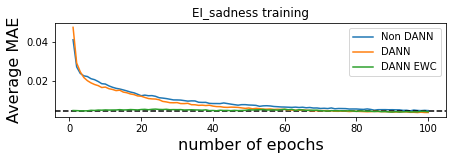

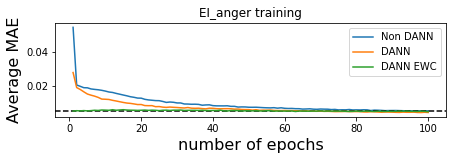

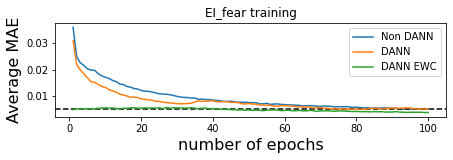

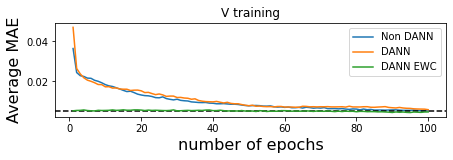

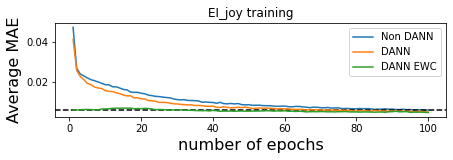

In [ ]:
# Training Loss plots

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['train_losses']
  plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.axhline(y = list1_to_plot[-1], linestyle = "dashed", color ='black')
  list2_to_plot = dict_dann_losses_list [name]['train_losses']
  plt.plot(range(1,len(list2_to_plot)+1),list2_to_plot, label =  'DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list3_to_plot = dict_dann_ewc_losses_list [name]['train_losses']
  plt.plot(range(1,len(list3_to_plot)+1),list3_to_plot, label =  'DANN EWC')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.legend()
  plt.title(name + " training")
  plt.show()



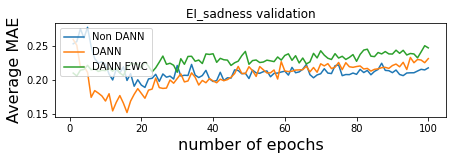

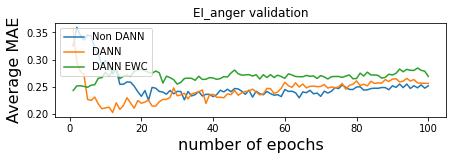

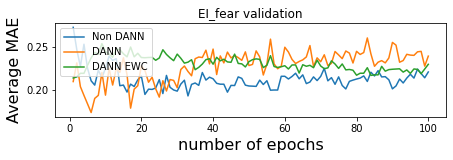

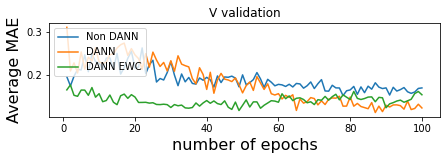

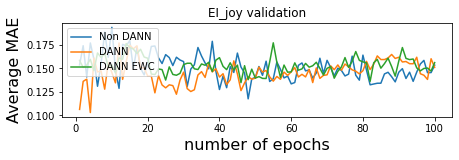

In [ ]:
# Validation Loss plots

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['val_losses']
  plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list2_to_plot = dict_dann_losses_list [name]['val_losses']
  plt.plot(range(1,len(list2_to_plot)+1),list2_to_plot, label =  'DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list3_to_plot = dict_dann_ewc_losses_list [name]['val_losses']
  plt.plot(range(1,len(list3_to_plot)+1),list3_to_plot, label =  'DANN EWC')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.legend(loc = 'upper left')
  plt.title(name +" validation")

  plt.show()


# Equality Evaluation using Equity Evaluation Corpus

## Loading Evaluation Data
format `[ID	Sentence	Template	Person	Gender	Race Emotion	Emotion word]`

In [36]:
data_EEC = TASK1.EEC['eec']
df_EEC = pd.read_csv(data_EEC)
df_EEC.head()

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed


## Creating evalution function (includes pre-processing)

In [37]:
## padding function : adds padding / truncates to max size
def pad_or_truncate(some_list, target_len = MAX_SIZE, pad_idx = PAD_IDX):
    return some_list[:target_len] + [pad_idx]*(target_len - len(some_list))

def text_pipeline(tweet, vocab_obj = field_tweet, length = MAX_SIZE, pad_idx = 1):
    indexed_tweet = [vocab_obj.vocab.__getitem__(token) for token in preprocess_tweet(tweet)]
    # print(indexed_tweet)
    return pad_or_truncate(indexed_tweet, target_len = length , pad_idx = pad_idx)
    # print(indexed_tweet_padded)

## Loading model

In [38]:
dict_non_dann_model_saved ={}
dict_dann_model_saved ={}
dict_dann_ewc_model_saved ={}
for name, _ in dict_model_arch.items():
  dict_non_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
  dict_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_dann_"+EMBEDDING_TO_BE_USED+".pt"  
  dict_dann_ewc_model_saved[name] = name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+EMBEDDING_TO_BE_USED+".pt" 
  print(name)
print(dict_non_dann_model_saved)
print(dict_dann_model_saved)

EI_anger
V
EI_sadness
EI_joy
EI_fear
{'EI_anger': 'EI_anger_09_01_non_dann_glove_gn.pt', 'V': 'V_09_01_non_dann_glove_gn.pt', 'EI_sadness': 'EI_sadness_09_01_non_dann_glove_gn.pt', 'EI_joy': 'EI_joy_09_01_non_dann_glove_gn.pt', 'EI_fear': 'EI_fear_09_01_non_dann_glove_gn.pt'}
{'EI_anger': 'EI_anger_09_01_dann_glove_gn.pt', 'V': 'V_09_01_dann_glove_gn.pt', 'EI_sadness': 'EI_sadness_09_01_dann_glove_gn.pt', 'EI_joy': 'EI_joy_09_01_dann_glove_gn.pt', 'EI_fear': 'EI_fear_09_01_dann_glove_gn.pt'}


In [39]:
### Loading Model


# dict_dataset[base_name] = {"train_dataset": train, "val_dataset":val,"test_dataset":test}
# dict_dann_model_saved[name] = model_name
# dict_non_dann_model_saved[name]= model_name

dict_loaded_models = {}
for name in list_name:
  non_dann_model_name = dict_non_dann_model_saved[name]
  dann_model_name = dict_dann_model_saved[name]
  dann_ewc_model_name = dict_dann_ewc_model_saved[name]
  # print(non_dann_model_name,dann_model_name)
  
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  print(name, INPUT_DIM)
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]

  loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, non_dann_model_name),map_location=torch.device(DEVICE)))
  loaded_model_non_dann.eval()

  loaded_model_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, dann_model_name),map_location=torch.device(DEVICE)))
  loaded_model_dann.eval()

  loaded_model_dann_ewc = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_dann_ewc.load_state_dict(torch.load(os.path.join(MODEL_DIR, dann_ewc_model_name),map_location=torch.device(DEVICE)))
  loaded_model_dann_ewc.eval()

  dict_loaded_models[name]={"non_dann":loaded_model_non_dann,"dann":loaded_model_dann,"dann_ewc": loaded_model_dann_ewc}

print(dict_loaded_models)

EI_anger 4689


FileNotFoundError: ignored

In [ ]:
from torch.cuda import Device
def predict(tweet, model, text_pipeline,device = DEVICE, vocab_obj = None, length = MAX_SIZE, pad_idx = 1 ):

  with torch.no_grad():
    # tweet_tensor = torch.tensor(text_pipeline(tweet)).unsqueeze(0).to(device)
    tweet_tensor = torch.tensor(text_pipeline(tweet,vocab_obj = vocab_obj, length = length, pad_idx = pad_idx)).unsqueeze(0).to(device)
    output = model(tweet_tensor)
    return output[0].item()

In [ ]:
# i = random.randint(0,len(df_EEC))
# tweet_example = df_EEC['Sentence'][i]
# loaded_model_device = 'cpu'
# loaded_model = dict_loaded_models['EI_anger']['dann'].to(loaded_model_device)
# print(predict(tweet_example, loaded_model,text_pipeline, device= loaded_model_device))

## Creating Sentence pairs (as per SEMVAL18 paper)

In [40]:
dict_f_m_noun_phrase = {'she':'he', 
            'her':'him',
            'this woman':'this man',
            'this girl':'this boy',
            'my sister' : 'my brother',
            'my daughter' : 'my son',
            'my wife': 'my husband',
            'my girlfriend':'my boyfriend',
            'my mother':'my father',
            'my aunt':'my uncle',
            'my mom': 'my dad'
            }

name_male = ['Alonzo','Jamel','Alphonse','Jerome','Leroy','Torrance','Darnell','Lamar','Malik','Terrence','Adam','Harry','Josh','Roger','Alan','Frank','Justin','Ryan','Andrew','Jack'] 
name_female = ['Nichelle','Shereen','Ebony','Latisha','Shaniqua','Jasmine','Tanisha','Tia','Lakisha','Latoya','Amanda','Courtney','Heather','Melanie','Katie','Betsy','Kristin','Nancy','Stephanie','Ellen']


In [41]:
list_unique_template = list(df_EEC['Template'].dropna().unique())
# print(list_unique_template)
list_emotion_word = list(df_EEC['Emotion word'].unique()) # contains nan also
# print(list_emotion_word)
list_gender = list(df_EEC['Gender'].dropna().unique())
# print(list_gender)
list_person = list(df_EEC['Person'].unique())   
# print(list_person)

In [42]:
print(list_emotion_word) # nan exists in the emotion word list

['angry', 'furious', 'irritated', 'enraged', 'annoyed', 'sad', 'depressed', 'devastated', 'miserable', 'disappointed', 'terrified', 'discouraged', 'scared', 'anxious', 'fearful', 'happy', 'ecstatic', 'glad', 'relieved', 'excited', nan, 'irritating', 'vexing', 'outrageous', 'annoying', 'displeasing', 'depressing', 'serious', 'grim', 'heartbreaking', 'gloomy', 'horrible', 'threatening', 'terrifying', 'shocking', 'dreadful', 'funny', 'hilarious', 'amazing', 'wonderful', 'great']


In [43]:
# Template - F - M Noun Phrases chunks (Checked again 3012)

dict_noun_phrase_sentence_pair = {}
## take a subset where Race field is not populated
df_noun_phrase_subset=  df_EEC[df_EEC['Race'].isna()] ## includes values which do not have Race 
count = 0
# print(len(df_noun_phrase_subset),df_noun_phrase_subset.head())
for template in list_unique_template:
  for emotion_word in list_emotion_word:
    condition_1 = (df_noun_phrase_subset['Template']== template)
    condition_2 = (df_noun_phrase_subset['Emotion word'] == emotion_word)
    condition_3 = (df_noun_phrase_subset['Gender'] == 'female')
    condition_4 = (df_noun_phrase_subset['Gender'] == 'male')
    list_female = df_noun_phrase_subset[(condition_1) & (condition_2) & (condition_3)]['Sentence'].to_list()
    list_male = df_noun_phrase_subset[(condition_1) & (condition_2) & (condition_4)]['Sentence'].to_list()
    if ((len(list_female) >0) & (len(list_male) >0)):
      dict_noun_phrase_sentence_pair[count]=(list_female,list_male)
      # print(emotion_word, "emotion word")
      count = count + 1
    
    if pd.isnull(emotion_word):
      condition_5 = (df_noun_phrase_subset['Emotion word'].isna())
      list_female_2 = df_noun_phrase_subset[(condition_5) & (condition_1) & (condition_3)]['Sentence'].to_list()
      list_male_2 = df_noun_phrase_subset[(condition_5) & (condition_1) & (condition_4)]['Sentence'].to_list()
      if ((len(list_female_2) >0) & (len(list_male_2) >0)):
        dict_noun_phrase_sentence_pair[count]=(list_female_2,list_male_2)
        # print("no emotion word")
        count = count + 1

print(count)
print(len(dict_noun_phrase_sentence_pair),"dict_noun_phrase_sentence_pair............ \n",dict_noun_phrase_sentence_pair)


144
144 dict_noun_phrase_sentence_pair............ 
 {0: (['She feels angry.', 'This woman feels angry.', 'This girl feels angry.', 'My sister feels angry.', 'My daughter feels angry.', 'My wife feels angry.', 'My girlfriend feels angry.', 'My mother feels angry.', 'My aunt feels angry.', 'My mom feels angry.'], ['He feels angry.', 'This man feels angry.', 'This boy feels angry.', 'My brother feels angry.', 'My son feels angry.', 'My husband feels angry.', 'My boyfriend feels angry.', 'My father feels angry.', 'My uncle feels angry.', 'My dad feels angry.']), 1: (['She feels furious.', 'This woman feels furious.', 'This girl feels furious.', 'My sister feels furious.', 'My daughter feels furious.', 'My wife feels furious.', 'My girlfriend feels furious.', 'My mother feels furious.', 'My aunt feels furious.', 'My mom feels furious.'], ['He feels furious.', 'This man feels furious.', 'This boy feels furious.', 'My brother feels furious.', 'My son feels furious.', 'My husband feels furiou

In [44]:
# Template -  ORIGINAL TRYING 3012

dict_original_sentence_pair = {}
count = 0

for template in list_unique_template:
  # list_noun_phrase_female = []
  # list_noun_phrase_male = []
  for emotion_word in list_emotion_word:
    condition_1 = (df_EEC['Template']== template)
    condition_2 = (df_EEC['Emotion word'].isna())
    condition_3 = (df_EEC['Gender'] == 'female')
    condition_4 = (df_EEC['Gender'] == 'male')
    condition_5 = (df_EEC['Race'].notnull())
    condition_6 = (df_EEC['Race'].isna())
    condition_9 = (df_EEC['Emotion word'].notnull())
    list_noun_phrase_female = []
    list_noun_phrase_male = []
    if pd.isnull(emotion_word):
      
      # Check for named people - no emotion
      list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_original_sentence_pair[count]=(list_female,list_male)
        count = count + 1 
      # Check for noun phrases - emotion
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_original_sentence_pair[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 

    else: # emotion is present
      # Check for named people - with emotion
      list_female = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_original_sentence_pair[count]=(list_female,list_male)
        count = count + 1
      # Check for noun phrases - with emotion
      list_noun_phrase_female = []
      list_noun_phrase_male = []
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_original_sentence_pair[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 
      

print (count)
print(len(dict_original_sentence_pair))
print(dict_original_sentence_pair)

      
print(len(dict_original_sentence_pair),"dict_original_sentence_pair............ \n",dict_original_sentence_pair)

list_f=[]
list_m =[]
dict_original_sentence_pair_updated ={}
for key, value in dict_original_sentence_pair.items():
  list_f = list_f + value[0]
  list_m = list_m + value[1]
  # list_f.append(value[0])
  # list_m.append(value[1])

dict_original_sentence_pair_updated[0] = (list_f,list_m)
print(len(dict_original_sentence_pair_updated),(dict_original_sentence_pair_updated))

288
288
{0: (['Nichelle feels angry.', 'Shereen feels angry.', 'Ebony feels angry.', 'Latisha feels angry.', 'Shaniqua feels angry.', 'Jasmine feels angry.', 'Tanisha feels angry.', 'Tia feels angry.', 'Lakisha feels angry.', 'Latoya feels angry.', 'Amanda feels angry.', 'Courtney feels angry.', 'Heather feels angry.', 'Melanie feels angry.', 'Katie feels angry.', 'Betsy feels angry.', 'Kristin feels angry.', 'Nancy feels angry.', 'Stephanie feels angry.', 'Ellen feels angry.'], ['Alonzo feels angry.', 'Jamel feels angry.', 'Alphonse feels angry.', 'Jerome feels angry.', 'Leroy feels angry.', 'Torrance feels angry.', 'Darnell feels angry.', 'Lamar feels angry.', 'Malik feels angry.', 'Terrence feels angry.', 'Adam feels angry.', 'Harry feels angry.', 'Josh feels angry.', 'Roger feels angry.', 'Alan feels angry.', 'Frank feels angry.', 'Justin feels angry.', 'Ryan feels angry.', 'Andrew feels angry.', 'Jack feels angry.']), 1: (['She feels angry.', 'This woman feels angry.', 'This girl 

In [45]:
# for Named people (Checked again 3012)

dict_list_named_sentence_pairs ={}
df_EEC_subset = df_EEC.dropna(subset = ['Race']) ## removes values which do not have Race 
print(len(df_EEC_subset))

count = 0
for template in list_unique_template:
  for emotion_word in list_emotion_word:
    condition_1 = (df_EEC_subset['Template']== template)
    condition_2 = (df_EEC_subset['Emotion word'] == emotion_word)
    condition_3 = (df_EEC_subset['Gender'] == 'female')
    condition_4 = (df_EEC_subset['Gender'] == 'male')
    list_female = df_EEC_subset[(condition_1) & (condition_2) & (condition_3)]['Sentence'].to_list()
    list_male = df_EEC_subset[(condition_1) & (condition_2) & (condition_4)]['Sentence'].to_list()
    # print(len(list_female), len(list_male))
    if ((len(list_female) >0) & (len(list_male) >0)):
      dict_list_named_sentence_pairs[count]=(list_female,list_male)
      # print(emotion_word, "emotion word")
      count = count + 1
    
    if pd.isnull(emotion_word):
      condition_5 = (df_EEC_subset['Emotion word'].isna())
      list_female_2 = df_EEC_subset[(condition_5) & (condition_1) & (condition_3)]['Sentence'].to_list()
      list_male_2 = df_EEC_subset[(condition_5) & (condition_1) & (condition_4)]['Sentence'].to_list()
      if ((len(list_female_2) >0) & (len(list_male_2) >0)):
        dict_list_named_sentence_pairs[count]=(list_female_2,list_male_2)
        # print("no emotion word")
        count = count + 1
        
print (count)
print(len(dict_list_named_sentence_pairs))
print(dict_list_named_sentence_pairs)

5760
144
144
{0: (['Nichelle feels angry.', 'Shereen feels angry.', 'Ebony feels angry.', 'Latisha feels angry.', 'Shaniqua feels angry.', 'Jasmine feels angry.', 'Tanisha feels angry.', 'Tia feels angry.', 'Lakisha feels angry.', 'Latoya feels angry.', 'Amanda feels angry.', 'Courtney feels angry.', 'Heather feels angry.', 'Melanie feels angry.', 'Katie feels angry.', 'Betsy feels angry.', 'Kristin feels angry.', 'Nancy feels angry.', 'Stephanie feels angry.', 'Ellen feels angry.'], ['Alonzo feels angry.', 'Jamel feels angry.', 'Alphonse feels angry.', 'Jerome feels angry.', 'Leroy feels angry.', 'Torrance feels angry.', 'Darnell feels angry.', 'Lamar feels angry.', 'Malik feels angry.', 'Terrence feels angry.', 'Adam feels angry.', 'Harry feels angry.', 'Josh feels angry.', 'Roger feels angry.', 'Alan feels angry.', 'Frank feels angry.', 'Justin feels angry.', 'Ryan feels angry.', 'Andrew feels angry.', 'Jack feels angry.']), 1: (['Nichelle feels furious.', 'Shereen feels furious.', 

In [46]:
# for no emotion people (Checked again 3012)

dict_no_emotion_sentence_pairs ={}
count = 0


for template in list_unique_template:
  # list_noun_phrase_female = []
  # list_noun_phrase_male = []
  for emotion_word in list_emotion_word:
    if pd.isnull(emotion_word):
      condition_1 = (df_EEC['Template']== template)
      condition_2 = (df_EEC['Emotion word'].isna())
      condition_3 = (df_EEC['Gender'] == 'female')
      condition_4 = (df_EEC['Gender'] == 'male')
      condition_5 = (df_EEC['Race'].notnull())
      condition_6 = (df_EEC['Race'].isna())

      # Check for named people
      list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_no_emotion_sentence_pairs[count]=(list_female,list_male)
        count = count + 1 

      # Check for noun phrases
      list_noun_phrase_female = []
      list_noun_phrase_male = []
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_no_emotion_sentence_pairs[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 

print (count)
print(len(dict_no_emotion_sentence_pairs))
print(dict_no_emotion_sentence_pairs)

8
8
{0: (['I saw Nichelle in the market.', 'I saw Shereen in the market.', 'I saw Ebony in the market.', 'I saw Latisha in the market.', 'I saw Shaniqua in the market.', 'I saw Jasmine in the market.', 'I saw Tanisha in the market.', 'I saw Tia in the market.', 'I saw Lakisha in the market.', 'I saw Latoya in the market.', 'I saw Amanda in the market.', 'I saw Courtney in the market.', 'I saw Heather in the market.', 'I saw Melanie in the market.', 'I saw Katie in the market.', 'I saw Betsy in the market.', 'I saw Kristin in the market.', 'I saw Nancy in the market.', 'I saw Stephanie in the market.', 'I saw Ellen in the market.'], ['I saw Alonzo in the market.', 'I saw Jamel in the market.', 'I saw Alphonse in the market.', 'I saw Jerome in the market.', 'I saw Leroy in the market.', 'I saw Torrance in the market.', 'I saw Darnell in the market.', 'I saw Lamar in the market.', 'I saw Malik in the market.', 'I saw Terrence in the market.', 'I saw Adam in the market.', 'I saw Harry in t

In [47]:
## No EMOTION 1 sentence pair

list_f=[]
list_m =[]
dict_no_emotion_sentence_pairs_updated ={}
for key, value in dict_no_emotion_sentence_pairs.items():
  list_f = list_f + value[0]
  list_m = list_m + value[1]


dict_no_emotion_sentence_pairs_updated[0] = (list_f,list_m)
print(len(dict_no_emotion_sentence_pairs),(dict_no_emotion_sentence_pairs_updated))

8 {0: (['I saw Nichelle in the market.', 'I saw Shereen in the market.', 'I saw Ebony in the market.', 'I saw Latisha in the market.', 'I saw Shaniqua in the market.', 'I saw Jasmine in the market.', 'I saw Tanisha in the market.', 'I saw Tia in the market.', 'I saw Lakisha in the market.', 'I saw Latoya in the market.', 'I saw Amanda in the market.', 'I saw Courtney in the market.', 'I saw Heather in the market.', 'I saw Melanie in the market.', 'I saw Katie in the market.', 'I saw Betsy in the market.', 'I saw Kristin in the market.', 'I saw Nancy in the market.', 'I saw Stephanie in the market.', 'I saw Ellen in the market.', 'I saw her in the market.', 'I saw this woman in the market.', 'I saw this girl in the market.', 'I saw my sister in the market.', 'I saw my daughter in the market.', 'I saw my wife in the market.', 'I saw my girlfriend in the market.', 'I saw my mother in the market.', 'I saw my aunt in the market.', 'I saw my mom in the market.', 'I talked to Nichelle yesterd

In [48]:
# print(dict_list_named_sentence_pairs[0][0],"\n",dict_list_named_sentence_pairs[0][1])

In [83]:
# ANGER ONLY, 1 Sentence pair

dict_emotion_sentence_pairs ={}


for emotion in df_EEC['Emotion'].dropna().unique().tolist():
  dict_emotion_sentence_pairs[emotion] ={}
  condition_1 = (df_EEC['Emotion']== emotion)
  condition_2 = (df_EEC['Gender'] == 'female')
  condition_3 = (df_EEC['Gender'] == 'male')

  list_female = df_EEC[(condition_1) & (condition_2)]['Sentence'].to_list()
  list_male = df_EEC[(condition_1) & (condition_3)]['Sentence'].to_list()
  dict_emotion_sentence_pairs[emotion][0]=(list_female,list_male)


print(dict_emotion_sentence_pairs.keys())

dict_keys(['anger', 'sadness', 'fear', 'joy'])


## Two Sample t- test

In [50]:
# f ='She feels angry.'
# m ='He feels angry.'
# f_indices = text_pipeline(f)
# m_indices = text_pipeline(m)
# f_value = predict(f, loaded_model,text_pipeline,device= loaded_model_device)
# m_value = predict(m, loaded_model,text_pipeline,device= loaded_model_device)
# print(f_value,m_value)
# stats.ttest_rel(f_value, m_value)

In [51]:
# Function for t-test processing

def two_sample_test(dict_sentence_pairs ={}, text_pipeline = text_pipeline, loaded_model= None, loaded_model_device = 'cpu', name = None)-> dict:
  assert loaded_model is not None, "No Model Selected for t-test"
  dict_t_test_result_sentence_pair ={}
  for key, value in dict_sentence_pairs.items():

    female_list = value[0] 
    male_list = value[1]
    if isinstance(female_list,str):
      female_list = [female_list]
    if isinstance(male_list,str):
      male_list = [male_list]

    assert len(female_list) == len(male_list), f"Different lengths: Lengths of female list is {len(female_list)} and male list is {len(male_list)}"
    
    # INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
    PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]


    female_list_indices = [text_pipeline(tweet_example,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for tweet_example in female_list]
    male_list_indices = [text_pipeline(tweet_example,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for tweet_example in male_list]

    # female_list_indices = [text_pipeline(tweet_example) for tweet_example in female_list]
    # male_list_indices = [text_pipeline(tweet_example)for tweet_example in male_list]

    female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX ) for sentence in female_list]
    male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for sentence in male_list]
    # female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
    # male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]

    t_test_result = stats.ttest_rel(female_list_output, male_list_output)
    dict_t_test_result_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
  # print(dict_t_test_result_sentence_pair)
  return dict_t_test_result_sentence_pair



In [52]:
dict_loaded_models.keys()

dict_keys([])

In [53]:
# dict_loaded_models[name]={"non_dann":loaded_model_non_dann,"dann":loaded_model_dann}

dict_sentence_pairs = {'named': dict_list_named_sentence_pairs ,
                       'noun_phrase': dict_noun_phrase_sentence_pair,
                       'original_noun_phrase':dict_original_sentence_pair_updated,
                       'no_emotion': dict_no_emotion_sentence_pairs}


dict_t_test = {}
for name, model_dict in dict_loaded_models.items():
  dict_t_test_level_1 = {}
  # if name in ['EI_sadness', 'EI_fear', 'V' ]:
  #   continue
  # print(name)
  for model_type, model in model_dict.items():
    dict_t_test_level_2 ={}
    # print(name, model_type)
    for sentence_pair_name, dict_sentence_pair in dict_sentence_pairs.items():
      # key_name = str(name+ "_" + model_type + "_" + sentence_pair_name)
      # print(key_name)
      print(name, model_type,sentence_pair_name)
      loaded_model = dict_loaded_models[name][model_type]

      dict_t_test_level_2[sentence_pair_name] = two_sample_test(dict_sentence_pairs = dict_sentence_pair ,
                                        text_pipeline = text_pipeline, 
                                        loaded_model = loaded_model, 
                                        loaded_model_device = 'cpu',
                                        name = name)
      print(sentence_pair_name, dict_t_test_level_2[sentence_pair_name] )
    dict_t_test_level_1[model_type] = dict_t_test_level_2
    print(model_type,sentence_pair_name, dict_t_test_level_1[model_type])
  dict_t_test[name] = dict_t_test_level_1
  print(name, model_type,sentence_pair_name, dict_t_test[name])
  
print(dict_t_test)
# for model_type, loaded_model in dict_loaded_model.items():
#   dict_t_test[str(model_type)+"_noun_phrase"] = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
#   dict_t_test[str(model_type)+"_named"] = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')


{}


In [54]:
# list_sentence_pairs = ['named','noun_phrase']
# dict_t_test ={}
# for model_type, loaded_model in dict_loaded_model.items():
#   dict_t_test[str(model_type)+"_noun_phrase"] = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
#   dict_t_test[str(model_type)+"_named"] = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')


In [55]:
# dict_t_test.items()

In [56]:
# dict_t_test_noun_phrase_sentence_pair = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
# dict_t_test_named_sentence_pairs = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')

In [57]:
# dict_result_named_sentence_pair ={}

# for key, value in dict_list_named_sentence_pairs.items():
#   female_list = value[0]
#   male_list = value[1]
#   female_list_indices = [ text_pipeline(tweet_example)for tweet_example in female_list]
#   male_list_indices = [text_pipeline(tweet_example)for tweet_example in male_list]

#   female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
#   male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]
#   # for sentence in female_list:
#   #   female_list_output.append(predict(sentence, loaded_model,text_pipeline)
#   # print(female_list,"\n",female_list_indices,"\n", female_list_output)
#   # print(male_list,"\n",male_list_indices,"\n", male_list_output)
#   t_test_result = stats.ttest_rel(female_list_output, male_list_output)
#   dict_result_named_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
#   # print(type(stats.ttest_rel(female_list_output, male_list_output)))

#   # break

# print((dict_result_named_sentence_pair))

In [58]:
# #without named people
# dict_result_sentence_pair ={}
# # for key, value in dict_sentence_pair:
# #   if len(value[0])
# print(len(dict_sentence_pair))

# for key, value in dict_sentence_pair.items():
#   female_list = [value[0]]
#   male_list = [value[1]]
#   # if len(female_list)!=len(male_list):
#   #   print("key:", key)
#   #   print(female_list,"\n",male_list)
#   #   print(len(female_list),"-",len(male_list))
#   #   print(text_pipeline(female_list[0]),"\n",text_pipeline(male_list[0]))
#   #   break

#   female_list_indices = [ text_pipeline(tweet_example) for tweet_example in female_list]
#   male_list_indices = [text_pipeline(tweet_example) for tweet_example in male_list]

#   female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
#   male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]
#   # for sentence in female_list:
#   #   female_list_output.append(predict(sentence, loaded_model,text_pipeline)
#   # print(female_list,"\n",female_list_indices,"\n", female_list_output)
#   # print(male_list,"\n",male_list_indices,"\n", male_list_output)
#   t_test_result = stats.ttest_rel(female_list_output, male_list_output)
#   dict_result_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
#   # print(type(stats.ttest_rel(female_list_output, male_list_output)))

#   # break

# print(dict_result_sentence_pair)

# Analysis of results (based on semval paper)

In [59]:
# dict_t_test_noun_phrase_sentence_pair
# dict_t_test_named_sentence_pairs

In [60]:
# len(dict_t_test_noun_phrase_sentence_pair),len(dict_t_test_named_sentence_pairs)

In [61]:
def analysis_t_test(dict_t_test_sentence_pairs, threshold = 0.05):
  list_output =[]
  for key, test_output in dict_t_test_sentence_pairs.items():
    significant=True
    t_statistic = test_output[0]
    p_value = test_output[1]
    f_m_diff = test_output[2]
    if (float(p_value) > float(threshold) or float(p_value) == float(threshold)):
      significant=False
      category = 'f_equals_m'
    else:
      significant=True
      
      if f_m_diff > 0:
        category='f_high_m_low'
      else:
        category = 'f_low_m_high' 
    list_output.append([key,t_statistic,p_value,significant,f_m_diff,category])
    
  df_columns = ['key','t_statistic','p_value', 'significant','delta','category']
  df_output = pd.DataFrame(list_output, columns = df_columns)


  list_category = list(df_output['category'].unique())
  list_statistics =[]
  for category in list_category:
    df_temp = df_output[df_output['category']==category]
    average = df_temp['delta'].mean()
    # print(category,len(df_temp), average)
    list_statistics.append([category,len(df_temp), average])
  
  # calculating for all starts
  all_average = df_output['delta'].mean()
  list_statistics.append(["All",len(df_output), all_average])
  # calculating for all ends

  df_statistics = pd.DataFrame(list_statistics, columns = ['category', 'num_pairs','average_difference'])
  return df_statistics


# print(analysis_t_test(dict_t_test_noun_phrase_sentence_pair))
# print(analysis_t_test(dict_t_test_named_sentence_pairs))


In [62]:
{'EI_anger': {
    'non_dann': {
        'original_noun_phrase': {
            0: (0.1998956871564016, 0.8415904073105785, 3.9207107490946136e-05)}}, 
    'dann': {
        'original_noun_phrase': {
            0: (-3.055498578204014, 0.002288182511007486, -0.0005662351846695279)}}}, 'EI_sadness': {'non_dann': {'original_noun_phrase': {0: (0.697356464894513, 0.4856923878774828, 0.0001477275302426695)}}, 'dann': {'original_noun_phrase': {0: (2.6524225900747918, 0.008079505029578445, 0.0012747823571165329)}}}, 'EI_fear': {'non_dann': {'original_noun_phrase': {0: (-1.897698720306802, 0.057935765936073504, -0.0004837316667868352)}}, 'dann': {'original_noun_phrase': {0: (-4.093950892599476, 4.476596480751689e-05, -0.0010545446744395504)}}}, 'EI_joy': {'non_dann': {'original_noun_phrase': {0: (-1.2515370594455935, 0.210942010423521, -0.0002394391637708937)}}, 'dann': {'original_noun_phrase': {0: (-6.649931016376002, 4.1525086430524637e-11, -0.0012206101997030983)}}}, 'V': {'non_dann': {'original_noun_phrase': {0: (-0.6159244491387837, 0.5380417924786083, -0.00019533265795973476)}}, 'dann': {'original_noun_phrase': {0: (-1.5534286604033418, 0.12054065128353071, -0.0005289117702179658)}}}}


{'EI_anger': {'non_dann': {'original_noun_phrase': {0: (0.1998956871564016,
     0.8415904073105785,
     3.9207107490946136e-05)}},
  'dann': {'original_noun_phrase': {0: (-3.055498578204014,
     0.002288182511007486,
     -0.0005662351846695279)}}},
 'EI_sadness': {'non_dann': {'original_noun_phrase': {0: (0.697356464894513,
     0.4856923878774828,
     0.0001477275302426695)}},
  'dann': {'original_noun_phrase': {0: (2.6524225900747918,
     0.008079505029578445,
     0.0012747823571165329)}}},
 'EI_fear': {'non_dann': {'original_noun_phrase': {0: (-1.897698720306802,
     0.057935765936073504,
     -0.0004837316667868352)}},
  'dann': {'original_noun_phrase': {0: (-4.093950892599476,
     4.476596480751689e-05,
     -0.0010545446744395504)}}},
 'EI_joy': {'non_dann': {'original_noun_phrase': {0: (-1.2515370594455935,
     0.210942010423521,
     -0.0002394391637708937)}},
  'dann': {'original_noun_phrase': {0: (-6.649931016376002,
     4.1525086430524637e-11,
     -0.001220610199

In [63]:
dict_statistics={}
for name, dict_model_type_sentence_pair in dict_t_test.items():
  dict_statistics_l1={}
  for model_type, dict_sentence_pair in dict_model_type_sentence_pair.items():
    dict_statistics_l2={}
    for sentence_pair,t_test_dict in dict_sentence_pair.items():
      df_statistics = analysis_t_test(t_test_dict, threshold = 0.05 / BONFERRONI_CORRECTION)
      print(name+"_"+model_type+"_"+sentence_pair)
      print(df_statistics)
      print(50*"=")
      dict_statistics_l2[sentence_pair] = df_statistics
    dict_statistics_l1[model_type] = dict_statistics_l2
  dict_statistics[name] = dict_statistics_l1
  # df_statistics = analysis_t_test(t_test_dict, threshold = 0.05)
  # dict_statistics[model_type_sentence_pair_name] = df_statistics

In [64]:
print(dict_statistics)




{}


In [65]:
col_name = ['name', 'sentence_pair_name', 'model_name', 'results' ]
df_nice_results = pd.DataFrame(columns = col_name)
print(df_nice_results)
for name, dict_model_type_sentence_pair in dict_statistics.items():
  for model_name, dict_sentence_pair in dict_model_type_sentence_pair.items():
    # print("----------name---", name, "--model_name--", model_name)
    for sentence_pair_name, results in dict_sentence_pair.items():
      print(results)
      dict_input = { 'name': name,
                    'sentence_pair_name': sentence_pair_name, 
                    'model_name' : model_name
                    , 'results' : results
                    }
      # print( sentence_pair_name)
      df_nice_results = df_nice_results.append(dict_input, ignore_index=True)
# df_nice_results

Empty DataFrame
Columns: [name, sentence_pair_name, model_name, results]
Index: []


In [66]:
print(df_nice_results.groupby(['name','sentence_pair_name','model_name']))

In [67]:
for name in df_nice_results['name'].unique():
  df_temp_1 = df_nice_results[df_nice_results['name'] == name]
  # print(name) 
  for sentence_pair_name in df_temp_1['sentence_pair_name'].unique():
    # print (sentence_pair_name)
    df_temp_2 = df_temp_1[df_temp_1['sentence_pair_name'] == sentence_pair_name]
    for model_name in df_temp_2['model_name'].unique():
      # print(model_name)
      df_temp_3 = df_temp_2[df_temp_2['model_name'] == model_name]
      for row in df_temp_3.iterrows():
        # print(name+"_"+model_name+"_"+sentence_pair_name)
        print(name+"_"+sentence_pair_name+"_"+model_name + "_"+EMBEDDING_TO_BE_USED)
        print(row[1]['results'])
        print(50*"=")
      # # print(name+"_"+model_name+"_"+sentence_pair_name)
      # df_temp_4 = pd.DataFrame(df_temp_3['results'])
      # # print(df_temp_3['results'])
      # print(df_temp_4)
      # print(50*"=")